# **O Case**
Dados históricos de dois anos de clientes de uma empresa que oferece streaming de musica baseado em assinatura.
Quando os usuários se inscrevem no serviço, eles podem optar por renovar o serviço manualmente ou renovar automaticamente, podendo cancelar ativamente sua associação à qualquer momento.

Quando os usuários se inscrevem no serviço, eles podem optar por renovar o serviço manualmente ou renovar automaticamente. Os usuários podem cancelar ativamente sua associação a qualquer momento.

Quando detectamos que um cliente não renova a assinatura, oferecemos 3 meses grátis. Porém, identificamos que essa ação é muito reativa e entendemos que uma abordagem proativa seria mais efetiva.

## **Modelo de Churn**
Criação de um modelo classificador para prever clientes que serão churn 3 meses no futuro (ou seja, clientes que possuem assinatura ativa no periodo analisado e 3 mses depois desse período ele não esta mais ativo, ou porque cancelou ou não renovou a assinatura) e identifique os clientes que serão direcionados para a ação de forma proativa.

Assume-se que, usando a ação de forma proativa, 50% dos clientes que iriam cancelar (Verdadeiro Positivo) respondem de forma positiva e continuam ativos por mais um ano.

## **Análise não supervisionada**
Considerando o modelo de churn desenvolvido, realizar uma análise não supervisionada dos clientes com objetivo de aprofundar a compreensão sobre características deles.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, DateType
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import (
accuracy_score, precision_score, recall_score, f1_score,
roc_auc_score, average_precision_score, confusion_matrix, log_loss, classification_report, precision_recall_curve
)
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import pickle

# Configuração do Spark
spark = (
    SparkSession.builder
    .appName("Spark Session")
    .getOrCreate()
)
spark

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
spark.sparkContext.setLogLevel("ERROR")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Extração dos dados e análise exploratória
- Loading dos arquivos parquet, referente as bases de dados do problema
- Base de transações, membros e logs
- Entendimento dos dados disponiveis

In [ ]:
# Loading das bases de dados
df_transactions = spark.read.parquet("/content/drive/MyDrive/Data Master/transactions.parquet")
df_members = spark.read.parquet("/content/drive/MyDrive/Data Master/members.parquet")
df_logs = spark.read.parquet("/content/drive/MyDrive/Data Master/user_logs.parquet")

### Base de transações

In [ ]:
# Transformação das colunas de data
df_transactions = df_transactions.select(
    F.col('msno'),
    F.col('payment_method_id').cast(DoubleType()),
    F.col('payment_plan_days').cast(DoubleType()),
    F.col('plan_list_price').cast(DoubleType()),
    F.col('actual_amount_paid').cast(DoubleType()),
    F.col('is_auto_renew').cast(IntegerType()),
    F.col('transaction_date'),
    F.col('membership_expire_date'),
    F.col('is_cancel').cast(IntegerType()),
    F.col('safra')
).withColumn(
    'transaction_date',
    F.to_date(F.concat(
                F.col('transaction_date').substr(1, 4),
                F.lit('-'),
                F.col('transaction_date').substr(5, 2),
                F.lit('-'),
                F.col('transaction_date').substr(7, 2)), 'yyyy-MM-dd')
).withColumn(
    'membership_expire_date',
    F.to_date(F.concat(
                F.col('membership_expire_date').substr(1, 4),
                F.lit('-'),
                F.col('membership_expire_date').substr(5, 2),
                F.lit('-'),
                F.col('membership_expire_date').substr(7, 2)), 'yyyy-MM-dd')
).withColumn(
    'safra',
    F.to_date(
        F.concat(
            F.col('safra').substr(1, 4),
            F.lit('-'),
            F.col('safra').substr(5, 2),
            F.lit('-'),
            F.lit('01')), 'yyyy-MM-dd')
)

### Base de membros

In [ ]:
df_members = df_members.select(
    F.col('msno'),
    F.col('city').cast(IntegerType()),
    F.col('bd').cast(IntegerType()),
    F.col('gender'),
    F.col('registered_via').cast(IntegerType()),
    F.col('registration_init_time'),
    F.col('is_ativo').cast(IntegerType()),
    F.col('safra')
).withColumn(
    'safra',
    F.to_date(
        F.concat(
            F.col('safra').substr(1, 4),
            F.lit('-'),
            F.col('safra').substr(5, 2),
            F.lit('-'),
            F.lit('01')), 'yyyy-MM-dd')
).withColumn(
    'registration_init_time',
    F.to_date(
        F.concat(
            F.col('registration_init_time').substr(1, 4),
            F.lit('-'),
            F.col('registration_init_time').substr(5, 2),
            F.lit('-'),
            F.col('registration_init_time').substr(7, 2)), 'yyyy-MM-dd')
)

### Base logs

In [ ]:
df_logs = df_logs.select(
    F.col('msno'),
    F.col('num_25').cast(DoubleType()),
    F.col('num_50').cast(DoubleType()),
    F.col('num_75').cast(DoubleType()),
    F.col('num_985').cast(DoubleType()),
    F.col('num_100').cast(DoubleType()),
    F.col('num_unq').cast(DoubleType()),
    F.col('total_secs').cast(DoubleType()),
    F.col('safra')
).withColumn(
    'safra',
    F.to_date(
        F.concat(
            F.col('safra').substr(1, 4),
            F.lit('-'),
            F.col('safra').substr(5, 2),
            F.lit('-'),
            F.lit('01')), 'yyyy-MM-dd')
)

# Definição de público
- Clientes que possuem assinatura ativa, utilizando a base de membros
- Como a base apresenta safras de todos os meses ao longo de 2016, utiliza-se o público até a safra de 2016-09-01 para que possuam apenas clientes que possamos saber o comportamento 3 meses para a frente (se ele será churn ou não)

In [ ]:
spine = df_members.filter(
    (F.col('is_ativo') == 1) &
    (F.col('safra') <= F.lit('2016-09-01'))
).dropDuplicates()

# Definição da target

Churn ou não churns, 3 meses no futuro

- Todas as variaveis sobre o cliente, estão em uma visao 3 meses antes da target
- É considerado como churn apenas os clientes que na safra 3 meses no futuro, não esta mais ativo.
- A partir da spine, com os clientes ativos em cada safra, é feito um cruzamento buscando o cliente na safra 3 meses para o futuro
- Cria-se a variável target, 1 para o cliente não ativo (churn), 0 para o cliente ativo (não churn)

In [ ]:
df_members_aliased = df_members.select('msno', 'safra', 'is_ativo').withColumnRenamed('safra', 'safra_target').withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra_target')))
df = spine.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.add_months(F.col('safra'), 3)))
df = df.join(df_members_aliased.select(
    'chave','safra_target', 'is_ativo'
    ).withColumn(
    'target', F.when(F.col('is_ativo') == 1, 0).otherwise(1)
    ).drop('is_ativo'),on='chave', how='left').drop('chave')

**Amostra**

Como se trata de uma base muito extensa, optou-se por realizar uma amostra estratificada utilizando 20% da base, para que garantir que se mantem as proporções da target da população.

In [ ]:
# Obtendo uma amostra, mantendo a proporção da target
fractions = {0: 0.2, 1: 0.2}  # Proporção de amostragem para cada classe

df_sample = df.sampleBy("target", fractions, seed=42)

#### *Considerações sobre público e a target*

1.   *Target desbalanceada* -> Há uma quantidade bem maior de clientes que continuaram ativos (1), que os clientes churn. Dessa forma, na criação do modelo, isso será tratado.
3.   *Horizonte do público em 2016* -> a target deve ser o cliente ativo ou nao, informação que é possivel de encontrar apenas na base de members, e portanto, temos apenas informações de 2016.


# Adição das informações de transações e logs

#### **Transações:**

*variaveis selecionadas da base:*
- payment_method_id -> metodo de pagamento
- is_auto_renew -> seria um indicativo de que o cliente talvez nao renove o plano?
- payment_plan_days -> indicando quanto tempo o cliente tem para renovar o plano
- plan_list_price -> indicando o valor tabelado da assinatura
- actual_amount_paid -> mostrando o quanto o cliente esta pagando, se for muito pode trazer indicios de cancelamento
- membership_expire_date -> transformar em quanto tempo para finalização do plano
- is_canceled -> indicando se o plano foi cancelado ou nao -> pode indicar que o cliente cancelou e no mes seguinte a assinatura nao estara mais ativa


In [ ]:
transactions=df_transactions.filter(F.year(F.col('safra'))=='2016')

In [ ]:
df_sample = df_sample.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra')))
df_sample = df_sample.join(transactions.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra'))).select('chave', 'is_auto_renew', 'payment_plan_days', 'plan_list_price','actual_amount_paid', 'membership_expire_date', 'is_cancel'),
                     on='chave', how='left')

#### **Logs:**

*variáveis selecionadas na base:*
1. num_25
2. num_50
3. num_75
4. num_985
5. num_100
6. num_unq
7. total_secs

In [ ]:
logs=df_logs.filter(F.year(F.col('safra'))=='2016')

In [ ]:
df_sample = df_sample.join(logs.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra'))).select('chave', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs'),
                     on='chave', how='left')

In [ ]:
# Salvando a amostra em formato CSV
output_csv_path = "dados/amostra.csv"
df_sample.toPandas().to_csv(output_csv_path, index=False)

# Análise da target
- Distribuição da target na amostra selecionada
- Analise da target ao longo das safras

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Data Master/dados/amostra.csv")

<ipython-input-5-82669921>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=data, palette=["#000000A6", "#970000AA"])


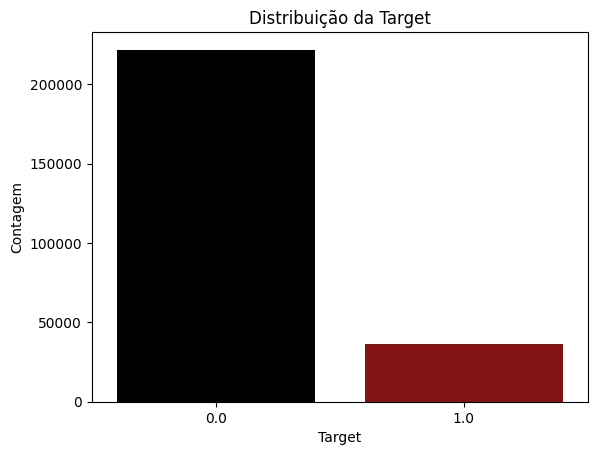

In [ ]:
# Distribuição da target
sns.countplot(x='target', data=data, palette=["#000000A6", "#970000AA"])
plt.title('Distribuição da Target')
plt.xlabel('Target')
plt.ylabel('Contagem')
plt.show()

In [ ]:
percentual_churn = data.groupby('safra')['target'].mean().reset_index()
percentual_churn.columns = ['safra', 'percentual_churn']
percentual_churn['percentual_churn'] = round(percentual_churn['percentual_churn'] * 100, 2)
mean_churn = percentual_churn['percentual_churn'].mean()

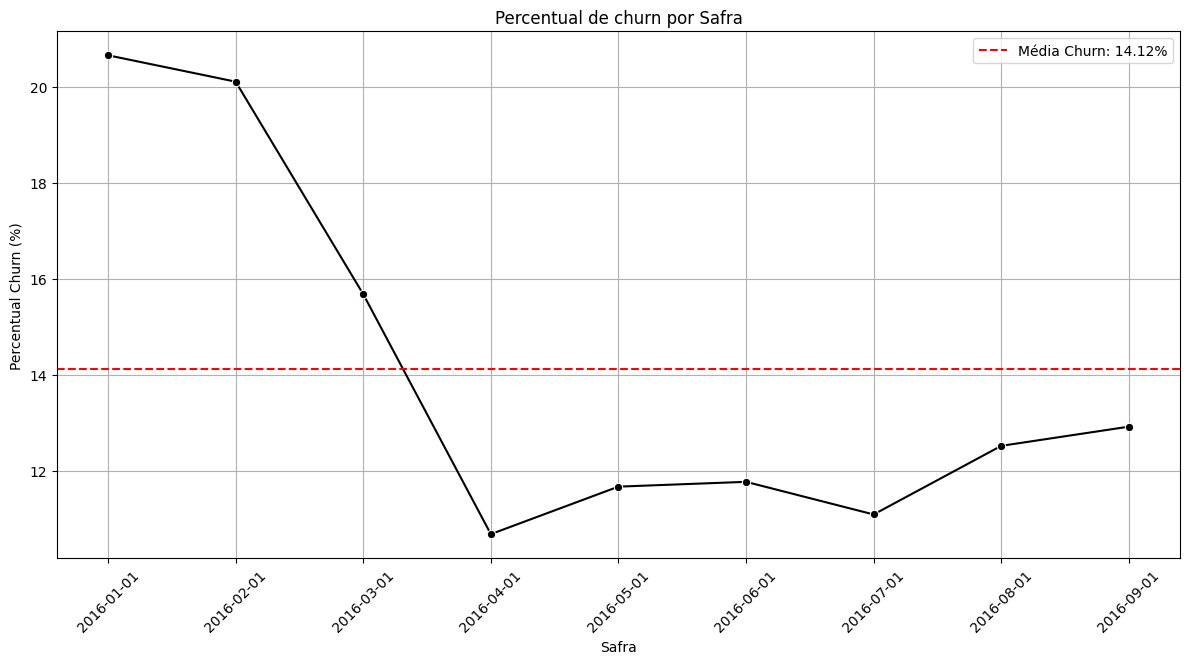

In [ ]:
# Analise temporal da variável target
plt.figure(figsize=(12, 6))
sns.lineplot(data=percentual_churn,x='safra', y='percentual_churn', marker='o', color="#000000")
plt.axhline(mean_churn, color='red', linestyle='--', label=f'Média Churn: {mean_churn:.2f}%')
plt.legend()
plt.grid()
plt.tight_layout()
plt.xlabel('Safra')
plt.ylabel('Percentual Churn (%)')
plt.title('Percentual de churn por Safra')
plt.xticks(rotation=45)
plt.show()

# Analise das variáveis e data-prep
















## Separação das bases de treino, teste, validação e oot
- Não serão utilizadas as safras 2016-01-01, 2016-02-01 e 2016-03-01 para o desenvolvimento do modelo, por apresentarem alto percentual de churn, destoando dos outros meses
- **Treino e teste**: 90% treino e teste, utilizando as safras de 2016-03-01 a 2016-08-01, separados depois em 80% pra treino e 20% teste
- **Validacao**: 10% da base, utilizando as safras de 2016-03-01 á 2016-08-01
- **OOT**: 100% da base na safra em 2016-09-01
- Garantiu-se a preservação do percentual de churn em todas as bases e baixa variação de churn ao longo das safras.

In [ ]:
data.groupby('safra').count()['msno']

,msno
safra,
2016-01-01,28398
2016-02-01,29156
2016-03-01,27373
2016-04-01,26237
2016-05-01,27194
2016-06-01,26564
2016-07-01,30556
2016-08-01,31264
2016-09-01,31468


In [ ]:
amostra_treino_validacao = (data.loc[data["safra"].isin(["2016-04-01", "2016-05-01", "2016-06-01", "2016-07-01", "2016-08-01"])][["msno"]].drop_duplicates().sample(frac = 0.8, random_state = 42, replace = False))

train = (amostra_treino_validacao.sample(frac = 0.9, random_state = 42, replace = False)[["msno"]].drop_duplicates())

valid = (amostra_treino_validacao.loc[~amostra_treino_validacao["msno"].isin(list(train["msno"].unique()))][["msno"]].drop_duplicates()) # retirada dos clientes presentes na base de treino

test = (data.loc[
            (data["safra"].isin(["2016-04-01", "2016-05-01", "2016-06-01", "2016-07-01", "2016-08-01"])) &
            (~data["msno"].isin(list(train["msno"].unique()))) & # retirada dos clientes presentes na base de treino
            (~data["msno"].isin(list(valid["msno"].unique())))][["msno"]].drop_duplicates() # retirada dos clientes presentes na base de validação
)

oot = (data.loc[(data["safra"].isin(["2016-09-01"]))][["msno"]].drop_duplicates())

train = train.merge(data.loc[data["safra"].isin(["2016-04-01", "2016-05-01", "2016-06-01", "2016-07-01", "2016-08-01"])], on = "msno", how = "left")
valid = valid.merge(data.loc[data["safra"].isin(["2016-04-01", "2016-05-01", "2016-06-01", "2016-07-01", "2016-08-01"])], on = "msno", how = "left")
test = test.merge(data.loc[data["safra"].isin(["2016-04-01", "2016-05-01", "2016-06-01", "2016-07-01", "2016-08-01"])], on = "msno", how = "left")
oot = oot.merge(data.loc[data["safra"].isin(["2016-09-01"])], on = "msno", how = "left")

In [ ]:
print('Total treino: ', train.count()['msno'])
print('Total teste: ', test.count()['msno'])
print('Total validação: ', valid.count()['msno'])
print('Total OOT: ', oot.count()['msno'])

Total treino:  102161
Total teste:  28318
Total validação:  11336
Total OOT:  31468


<ipython-input-11-2992535249>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data_plot, x='target', y='perc', label=name, palette=custom_palette)


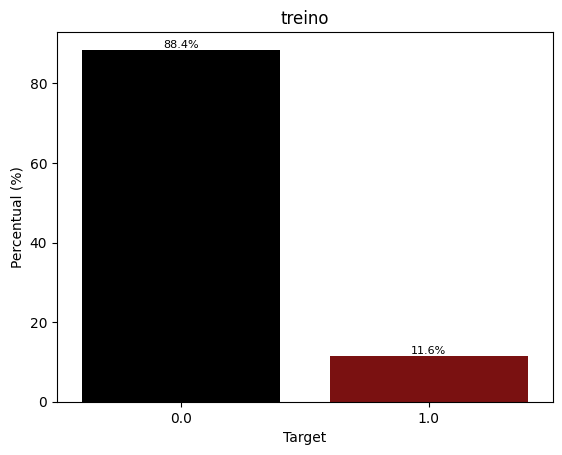

<ipython-input-11-2992535249>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data_plot, x='target', y='perc', label=name, palette=custom_palette)


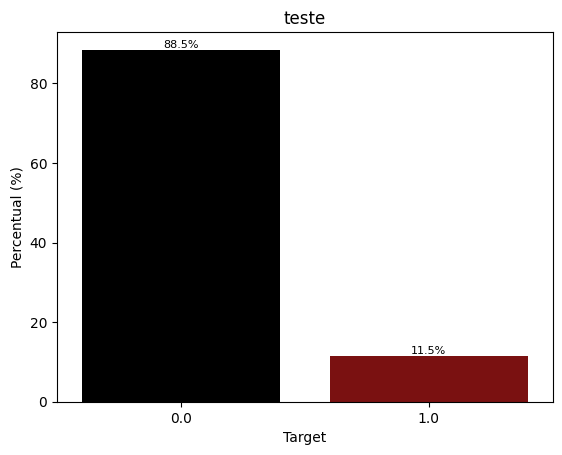

<ipython-input-11-2992535249>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data_plot, x='target', y='perc', label=name, palette=custom_palette)


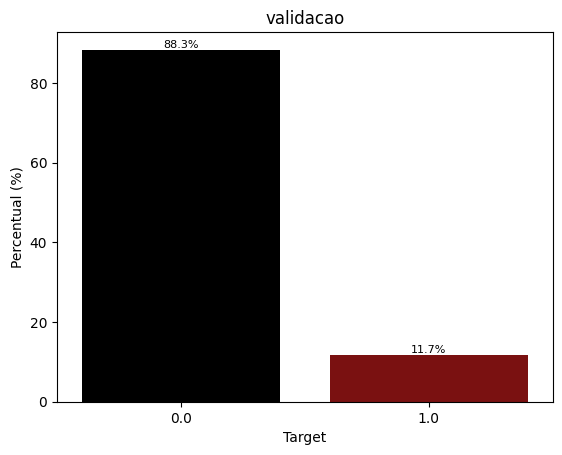

<ipython-input-11-2992535249>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data_plot, x='target', y='perc', label=name, palette=custom_palette)


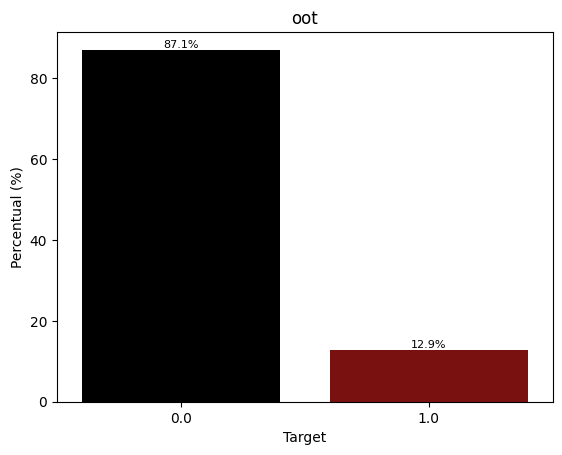

In [ ]:
def contagem(df):
    return df.groupby('target', as_index=False).count().rename(columns={'msno': 'count'}).assign(perc=lambda x: x['count'] / x['count'].sum() * 100)

def plot_churn(df, name):
    custom_palette = ["#000000", "#8B0000"]
    data_plot = contagem(df)
    ax = sns.barplot(data=data_plot, x='target', y='perc', label=name, palette=custom_palette)
    plt.xlabel('Target')
    plt.ylabel('Percentual (%)')
    plt.title(name)

    # Adiciona o rótulo em cada barra
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.1f}%',
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=8, color='black')

    plt.show()

plot_churn(train, 'treino')
plot_churn(test, 'teste')
plot_churn(valid, 'validacao')
plot_churn(oot, 'oot')


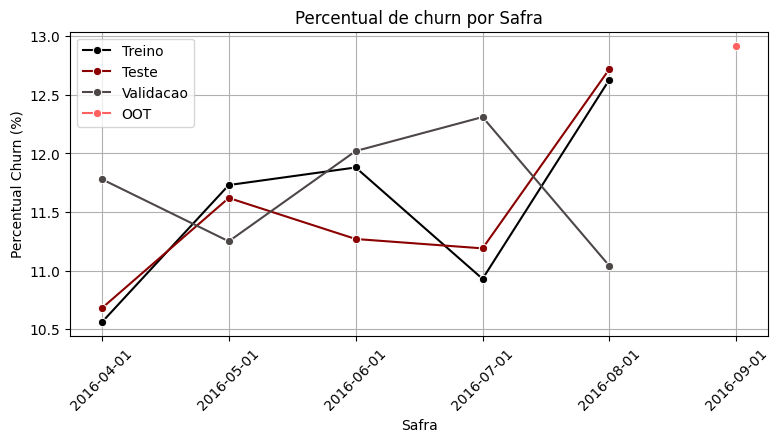

In [ ]:
def perc_churn(df, name):
    """
    Função para calcular o percentual de churn em um DataFrame.
    """
    aux = df.groupby('safra')['target'].mean().reset_index()
    aux.columns = ['safra', f'percentual_churn_{name}']
    aux[f'percentual_churn_{name}'] = round(aux[f'percentual_churn_{name}'] * 100, 2)
    return aux

# Calculando o percentual de churn para cada conjunto de dados
train_churn = perc_churn(train, 'treino')
test_churn = perc_churn(test, 'teste')
valid_churn = perc_churn(valid, 'validacao')
oot_churn = perc_churn(oot, 'oot')

# Analise temporal da variável target
plt.figure(figsize=(8, 4))
sns.lineplot(data=train_churn,x='safra', y='percentual_churn_treino', marker='o', label='Treino', color="#000000")
sns.lineplot(data=test_churn,x='safra', y='percentual_churn_teste', marker='o', label='Teste', color="#8B0000")
sns.lineplot(data=valid_churn,x='safra', y='percentual_churn_validacao', marker='o', label='Validacao', color="#4D4747")
sns.lineplot(data=oot_churn,x='safra', y='percentual_churn_oot', marker='o', label='OOT',   color="#FF6161")
plt.xlabel('Safra')
plt.ylabel('Percentual Churn (%)')
plt.title('Percentual de churn por Safra')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

## Análise das variáveis

**Valores missing**

In [ ]:
null_counts = train.isnull().sum()
null_percent = (null_counts / len(data)) * 100
null_summary = pd.DataFrame({'null_count': null_counts, 'null_percent': null_percent.round(2)})
null_summary

,null_count,null_percent
msno,0,0.00
chave,0,0.00
city,0,0.00
bd,0,0.00
gender,49895,19.32
registered_via,0,0.00
registration_init_time,0,0.00
is_ativo,0,0.00
safra,0,0.00
safra_target,0,0.00


**Seleção inicial das features**

Features Categóricas: city, registered_via, is_auto_renew, is_cancel

Features Numéricas: bd, payment_plan_days, actual_amount_paid, num_25, num_50, num_75, num_985, num_100, num_unq, total_secs

Optou-se em não utilizar a variavel gender, que indica o genero do cliente, para não incluir um viés antietico e garantir que não sejam reforçadas desigualdades nas decisões do modelo.

In [ ]:
# Separação das features categorias e numericas
cat_cols = ['city', 'registered_via', 'is_auto_renew','is_cancel']
num_cols = ['bd', 'payment_plan_days', 'actual_amount_paid', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']

**Variáveis categóricas**

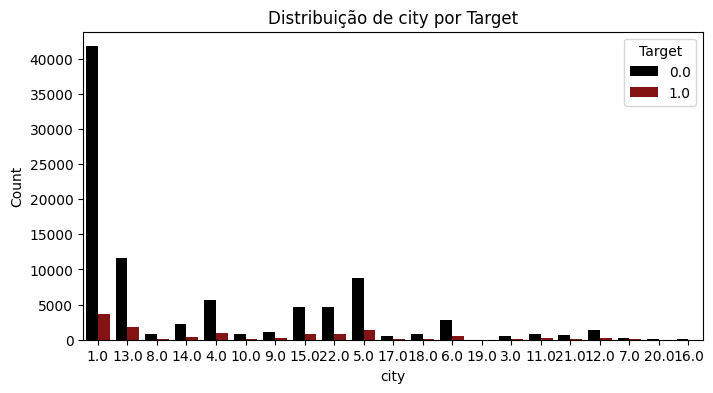

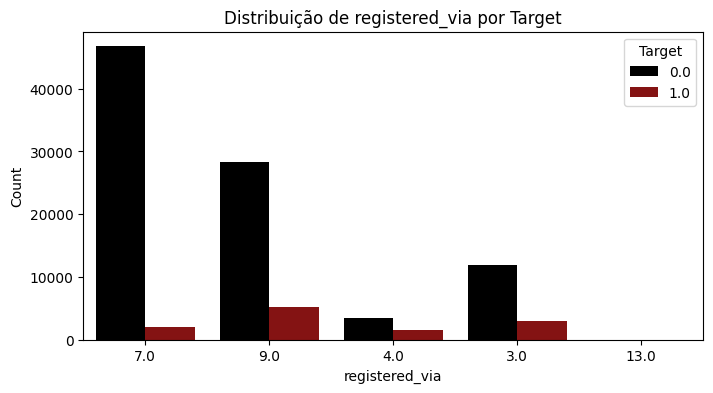

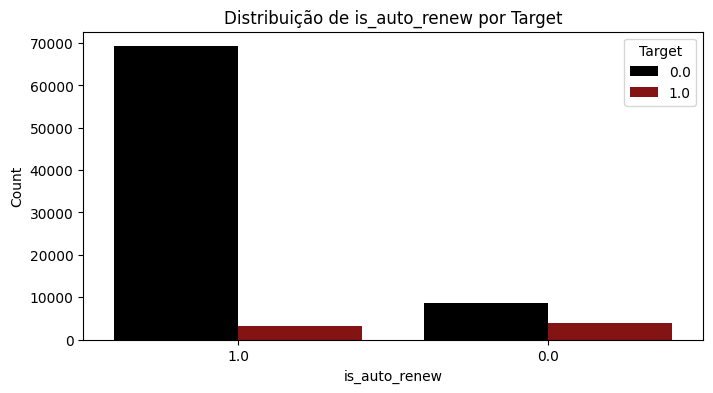

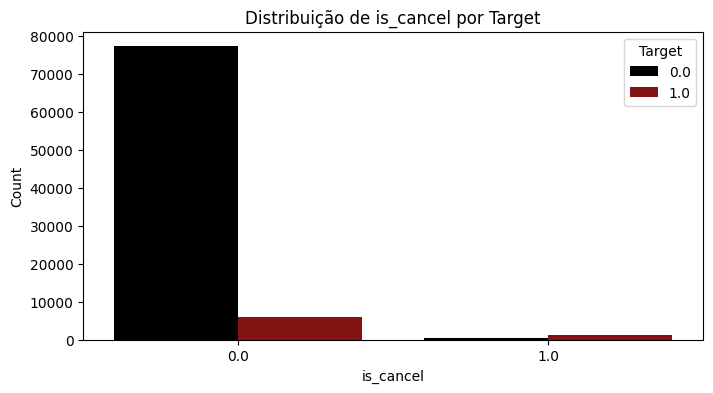

In [ ]:
for i in cat_cols:
  train[i] = train[i].astype('string')
  plt.figure(figsize=(8, 4))
  sns.countplot(data=train, x=i, hue='target', palette=["#000000A6", "#970000AA"])
  plt.title(f'Distribuição de {i} por Target')
  plt.xlabel(i)
  plt.ylabel('Count')
  plt.legend(title='Target', loc='upper right')
  plt.show()

In [ ]:
for i in cat_cols:
    display(train.groupby(i)[['target']].mean().assign(target=lambda x: round(x['target'] * 100, 2)).rename(columns={'target': 'percentual_churn'}).sort_values('percentual_churn', ascending=False).T)

city,9.0,11.0,12.0,20.0,21.0,15.0,22.0,10.0,6.0,4.0,8.0,5.0,13.0,14.0,3.0,17.0,18.0,7.0,16.0,19.0,1.0
percentual_churn,20.82,17.7,16.03,15.73,15.57,15.07,14.68,14.45,14.28,14.25,14.05,13.81,13.71,13.63,13.31,13.08,12.31,10.36,9.92,9.52,8.09


registered_via,4.0,3.0,9.0,7.0,13.0
percentual_churn,30.32,20.41,15.64,4.15,0.0


is_auto_renew,0.0,1.0
percentual_churn,31.91,4.33


is_cancel,1.0,0.0
percentual_churn,68.3,7.17


**Variáveis numéricas**

In [ ]:
train[num_cols].describe(percentiles=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9, 0.95, 0.98 ,0.99])

,bd,payment_plan_days,actual_amount_paid,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,102161.000000,84882.000000,84882.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,9.137900e+04
mean,15.622743,31.797566,139.610954,114.528787,28.740476,18.008591,20.255956,536.278642,526.428807,1.417093e+05
std,21.615751,18.493324,80.591941,204.379566,41.606832,24.136265,44.821325,759.045604,611.626711,1.851529e+05
min,-51.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.350000e-01
5%,0.000000,30.000000,99.000000,2.000000,0.000000,0.000000,0.000000,8.000000,14.000000,2.829981e+03
10%,0.000000,30.000000,99.000000,6.000000,1.000000,1.000000,1.000000,27.000000,37.000000,8.278501e+03
20%,0.000000,30.000000,99.000000,14.000000,4.000000,3.000000,3.000000,76.000000,94.000000,2.222889e+04
30%,0.000000,30.000000,99.000000,26.000000,7.000000,5.000000,5.000000,139.000000,163.000000,3.949104e+04
40%,0.000000,30.000000,149.000000,40.000000,11.000000,7.000000,8.000000,213.000000,243.000000,5.936546e+04
50%,18.000000,30.000000,149.000000,58.000000,16.000000,11.000000,11.000000,301.000000,337.000000,8.308057e+04


In [ ]:
def numeric_summary_by_target(df, numerical_cols, target_col):
    summary_dict = {}
    for col in numerical_cols:
        summary_dict[col] = df.groupby(target_col)[col].agg(['mean', 'median', 'min', 'max',]).round(2)
    return pd.concat(summary_dict, axis=0)

numeric_summary_table = numeric_summary_by_target(train, num_cols, 'target')

display(numeric_summary_table)

mean    median    min         max
                   target                                        
bd                 0.0         15.21      0.00 -51.00     1958.00
                   1.0         18.75     22.00 -43.00     1032.00
payment_plan_days  0.0         32.20     30.00   1.00      395.00
                   1.0         27.36     30.00   2.00      410.00
actual_amount_paid 0.0        141.34    149.00   0.00     1000.00
                   1.0        120.74    149.00   0.00      450.00
num_25             0.0        116.02     59.00   0.00    30483.00
                   1.0        102.82     51.00   0.00     5386.00
num_50             0.0         29.10     16.00   0.00     1768.00
                   1.0         25.96     13.00   0.00      677.00
num_75             0.0         18.28     11.00   0.00      976.00
                   1.0         15.92      9.00   0.00      345.00
num_985            0.0         20.59     11.00   0.00     4902.00
                   1.0         17.64      9.00   0.00     2596.00
num_100            0.0        544.52    310.00   0.00    33281.00
                   1.0        471.76    237.00   0.00    11245.00
num_unq            0.0        535.72    347.00   1.00     8870.00
                   1.0        453.66    264.00   1.00     6160.00
total_secs         0.0     143841.92  85325.41   0.24  2880453.15
                   1.0     125013.33  65314.08   1.02  1941550.77

## Criação de novas features
- tempo_expiracao : utilizar os tempo da safra atual até a data de expiracao do plano. Para os valores nulos, utiliza-se o valor médio do tempo de expiracao.
- tempo_iniciacao : tempo desde que se tornou membro pela primeira vez

In [ ]:
train['tempo_expiracao'] = (pd.to_datetime(train['membership_expire_date']) - pd.to_datetime(train['safra'])).dt.days
train['tempo_iniciacao'] = (pd.to_datetime(train['safra']) - pd.to_datetime(train['registration_init_time'])).dt.days
test['tempo_expiracao'] = (pd.to_datetime(test['membership_expire_date']) - pd.to_datetime(test['safra'])).dt.days
test['tempo_iniciacao'] = (pd.to_datetime(test['safra']) - pd.to_datetime(test['registration_init_time'])).dt.days
valid['tempo_expiracao'] = (pd.to_datetime(valid['membership_expire_date']) - pd.to_datetime(valid['safra'])).dt.days
valid['tempo_iniciacao'] = (pd.to_datetime(valid['safra']) - pd.to_datetime(valid['registration_init_time'])).dt.days
oot['tempo_expiracao'] = (pd.to_datetime(oot['membership_expire_date']) - pd.to_datetime(oot['safra'])).dt.days
oot['tempo_iniciacao'] = (pd.to_datetime(oot['safra']) - pd.to_datetime(oot['registration_init_time'])).dt.days

In [ ]:
train[['tempo_expiracao', 'tempo_iniciacao']].describe(percentiles=[0.01,0.025, 0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9, 0.95, 0.98 ,0.99])

,tempo_expiracao,tempo_iniciacao
count,84882.000000,102161.000000
mean,49.674536,1146.124568
std,22.614545,1063.515195
min,-1.000000,-30.000000
1%,17.000000,-15.000000
2.5%,30.000000,4.000000
10%,33.000000,102.000000
20%,36.000000,204.000000
30%,40.000000,324.000000
40%,44.000000,604.000000


# Pré-processamento

### **Tratamento dos nulos**

**Transações**

Para as colunas provenientes da base de transações, assume-se que os valores nulos são provenientes de cliente com plano com renovação maior que um mês. Nesse caso o cliente não realizou transferencia no mes, mas continua ativo (membership_expire_date > safra).

Utiliza-se entao, os valores medios das transacoes com payment_plan_days maior que 30 dias para as colunas payment_plan_days, actual_amount_paid, is_auto_renew

In [ ]:
transacoes = df_transactions.filter((F.col('payment_plan_days')> 30)&(F.col('safra')<='2016-08-01'))

In [ ]:
ids = train[train['payment_plan_days'].isnull()]['msno'].unique().tolist()

In [ ]:
transacoes = transacoes.filter(F.col('msno').isin(ids))

In [ ]:
payment_plan_days = transacoes.agg(F.mean('payment_plan_days')).collect()[0][0]
plan_list_price = transacoes.agg(F.mean('plan_list_price')).collect()[0][0]
actual_amount_paid = transacoes.agg(F.mean('actual_amount_paid')).collect()[0][0]
train['payment_plan_days'] = train['payment_plan_days'].fillna(payment_plan_days)
train['plan_list_price'] = train['plan_list_price'].fillna(plan_list_price)
train['actual_amount_paid'] = train['actual_amount_paid'].fillna(actual_amount_paid)
test['payment_plan_days'] = test['payment_plan_days'].fillna(payment_plan_days)
test['plan_list_price'] = test['plan_list_price'].fillna(plan_list_price)
test['actual_amount_paid'] = test['actual_amount_paid'].fillna(actual_amount_paid)
valid['payment_plan_days'] = valid['payment_plan_days'].fillna(payment_plan_days)
valid['plan_list_price'] = valid['plan_list_price'].fillna(plan_list_price)
valid['actual_amount_paid'] = valid['actual_amount_paid'].fillna(actual_amount_paid)
oot['payment_plan_days'] = oot['payment_plan_days'].fillna(payment_plan_days)
oot['plan_list_price'] = oot['plan_list_price'].fillna(plan_list_price)
oot['actual_amount_paid'] = oot['actual_amount_paid'].fillna(actual_amount_paid)

**Váriáveis categóricas**

Para as variaveis categóricas, opta-se por criar uma nova categoria 'sem_registro'

In [ ]:
for col in cat_cols:
    train[col] = train[col].fillna('sem_registro')
    test[col] = test[col].fillna('sem_registro')
    valid[col] = valid[col].fillna('sem_registro')
    oot[col] = oot[col].fillna('sem_registro')

In [ ]:
train.head()

,msno,chave,city,bd,gender,registered_via,registration_init_time,is_ativo,safra,safra_target,target,is_auto_renew,payment_plan_days,plan_list_price,actual_amount_paid,membership_expire_date,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,tempo_expiracao,tempo_iniciacao
0,zp1fkpGmGRdHidzu0rARjtQmrBCazmHEOLdck5wMp3o=,zp1fkpGmGRdHidzu0rARjtQmrBCazmHEOLdck5wMp3o=_2...,1.0,0.0,NaN,7.0,2015-08-04,1.0,2016-05-01,2016-08-01,0.0,1.0,30.0,99.0,99.0,2016-06-04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0,271
1,YnQUHn4iid3ntFGo9drmZUgHOBtqE4W2wyMbQ5EPXyA=,YnQUHn4iid3ntFGo9drmZUgHOBtqE4W2wyMbQ5EPXyA=_2...,13.0,29.0,female,7.0,2012-06-14,1.0,2016-04-01,2016-07-01,0.0,1.0,30.0,149.0,149.0,2016-05-15,0.0,283.0,62.0,41.0,45.0,5179.0,3335.0,1251116.093,44.0,1387
2,NpidcMRW6UP/Y+CtsmwQ2EeHlOnH8uNrhjPo4hfhy0I=,NpidcMRW6UP/Y+CtsmwQ2EeHlOnH8uNrhjPo4hfhy0I=_2...,13.0,25.0,female,7.0,2014-06-05,1.0,2016-05-01,2016-08-01,0.0,1.0,30.0,129.0,129.0,2016-05-15,1.0,138.0,44.0,24.0,19.0,1229.0,1322.0,300332.541,14.0,696
3,/lWUM1gUbQNqgALnmbRRLiuQxuwdKO68f3Sx0tauoLU=,/lWUM1gUbQNqgALnmbRRLiuQxuwdKO68f3Sx0tauoLU=_2...,1.0,0.0,NaN,7.0,2014-01-11,1.0,2016-08-01,2016-11-01,0.0,1.0,30.0,149.0,149.0,2016-09-10,0.0,58.0,27.0,20.0,11.0,1108.0,483.0,243377.255,40.0,933
4,Z7wUDfcT+/Ru/kYR3b3ajGHQXBEubfKjWGpvaY3nvL0=,Z7wUDfcT+/Ru/kYR3b3ajGHQXBEubfKjWGpvaY3nvL0=_2...,8.0,26.0,male,9.0,2010-12-24,1.0,2016-06-01,2016-09-01,0.0,1.0,30.0,149.0,149.0,2016-07-23,0.0,33.0,15.0,10.0,18.0,919.0,924.0,240312.504,52.0,1986


**Variáveis numéricas**

Conceitualmente a variável tempo_de_iniciacao, que representa a quanto tempo o cliente esta regisrado na plataforma, os valores como nulos podem representar clientes recém iniciados, e portanto opta-se em mantere o valor zero para esses casos.

Para o restante das variaveis numericas, opta-se em preencher os valores nulos com a média da variável na base de treino.

In [ ]:
# Váriavel tempo_de_iniciacao
train['tempo_iniciacao'] = train['tempo_iniciacao'].fillna(0)
test['tempo_iniciacao'] = test['tempo_iniciacao'].fillna(0)
valid['tempo_iniciacao'] = valid['tempo_iniciacao'].fillna(0)
oot['tempo_iniciacao'] = oot['tempo_iniciacao'].fillna(0)

In [ ]:
num_cols.append('tempo_expiracao')
for col in num_cols:
    train[col] = train[col].astype('float64')
    test[col] = test[col].astype('float64')
    valid[col] = valid[col].astype('float64')
    oot[col] = oot[col].astype('float64')
    mean = train[col].mean()
    train[col] = train[col].fillna(mean)
    test[col] = test[col].fillna(mean)
    valid[col] = valid[col].fillna(mean)
    oot[col] = oot[col].fillna(mean)

### **Tratamento de outliers**

Observa-se que algumas variaveis numericas possuem outliers, e então decide-se utilizar como maximo o percentile 0.99 e como minimo o percentile 0.01.

A variavel bd, que representa a idade do cliente membro, apresenta alguns valores maiores que 100 anos possui e muitos valores iguais ou menores que zero, algo que não faz sentido. Desta forma, separa-se apenas os valores maior que zero e até 100, e entao utiliza-se o percentile 0.01 e 0.99 dessa amostra, para servirem como minimos e maximos para essa variavel.

Para o tempo de iniciação, foram observados alguns valores negativos, desta forma, usa-se como piso o valor do percentile 0.025.

In [ ]:
aux = train[(train['bd']>0)&(train['bd']<100)]
p1 = aux['bd'].quantile(0.01)
p99 = aux['bd'].quantile(0.99)
train['bd'] = np.where(train['bd'] < p1, p1, train['bd'])
train['bd'] = np.where(train['bd'] > p99, p99, train['bd'])
test['bd'] = np.where(test['bd'] < p1, p1, test['bd'])
test['bd'] = np.where(test['bd'] > p99, p99, test['bd'])
valid['bd'] = np.where(valid['bd'] < p1, p1, valid['bd'])
valid['bd'] = np.where(valid['bd'] > p99, p99, valid['bd'])
oot['bd'] = np.where(oot['bd'] < p1, p1, oot['bd'])
oot['bd'] = np.where(oot['bd'] > p99, p99, oot['bd'])

In [ ]:
for i in num_cols:
    if i == 'bd':
        pass
    if i == 'tempo_iniciacao':
        p99 = train[i].quantile(0.99)
        p025 = train[i].quantile(0.025)
        train[i] = train[i].clip(lower=p025, upper=p99, axis=0)
        test[i] = test[i].clip(lower=p025, upper=p99, axis=0)
        valid[i] = valid[i].clip(lower=p025, upper=p99, axis=0)
        oot[i] = oot[i].clip(lower=p025, upper=p99, axis=0)
    p99 = train[i].quantile(0.99)
    p1 = train[i].quantile(0.01)
    train[i] = train[i].clip(lower=p1, upper=p99, axis=0)
    test[i] = test[i].clip(lower=p1, upper=p99, axis=0)
    valid[i] = valid[i].clip(lower=p1, upper=p99, axis=0)
    oot[i] = oot[i].clip(lower=p1, upper=p99, axis=0)

In [ ]:
# Retirando colunas que não serão utilizadas
drop_cols = ['chave','registration_init_time','membership_expire_date', 'is_ativo', 'safra_target']
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)
valid = valid.drop(columns=drop_cols)
oot = oot.drop(columns=drop_cols)

## **Encoding das variaveis categóricas**

Para o pré-processamento das variaveis categóricas, utiliza-se um target encoding. Desta forma, aproveita-se a relação da variável com a target, não se aumenta a dimensionalidade da variavel (como com o one-hot-encoding) e pode auxiliar no desempenho de modelos de booting, como XGBoost.


In [ ]:
cat_cols = ['city', 'registered_via','is_auto_renew', 'is_cancel']
num_cols = ['bd', 'payment_plan_days', 'plan_list_price', 'actual_amount_paid',
            'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs',
            'tempo_expiracao', 'tempo_iniciacao']
for i in cat_cols:
    train[i] = train[i].astype('str')
    test[i] = test[i].astype('str')
    valid[i] = valid[i].astype('str')
    oot[i] = oot[i].astype('str')
for i in num_cols:
    train[i] = train[i].astype('float64')
    test[i] = test[i].astype('float64')
    valid[i] = valid[i].astype('float64')
    oot[i] = oot[i].astype('float64')


In [ ]:
# target encoding para as variaveis categóricas

def target_encode(train, test, valid, oot, cat_cols, target_col):
    for col in cat_cols:
        # Calcula a média do target para cada categoria
        mean_target = train.groupby(col)[target_col].mean().to_dict()

        # Mapeia a média do target para cada categoria no conjunto de treino
        train[col+'_te'] = train[col].map(mean_target).fillna(train[target_col].mean())
        test[col+'_te'] = test[col].map(mean_target).fillna(train[target_col].mean())
        valid[col+'_te'] = valid[col].map(mean_target).fillna(train[target_col].mean())
        oot[col+'_te'] = oot[col].map(mean_target).fillna(train[target_col].mean())

        # Converte a coluna de target encoding para float64
        train[col+'_te'] = train[col+'_te'].astype('float64')
        test[col+'_te'] = test[col+'_te'].astype('float64')
        valid[col+'_te'] = valid[col+'_te'].astype('float64')
        oot[col+'_te'] = oot[col+'_te'].astype('float64')
    return train, test, valid, oot
train, test, valid, oot = target_encode(train, test, valid, oot, cat_cols, 'target')

In [ ]:
train.head()

,msno,city,bd,gender,registered_via,safra,target,is_auto_renew,payment_plan_days,plan_list_price,actual_amount_paid,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,tempo_expiracao,tempo_iniciacao,city_te,gender_te,registered_via_te,is_auto_renew_te,is_cancel_te
0,zp1fkpGmGRdHidzu0rARjtQmrBCazmHEOLdck5wMp3o=,1.0,17.0,nan,7.0,2016-05-01,0.0,1.0,30.0,99.0,99.0,0.0,114.528787,28.740476,18.008591,20.255956,536.278642,526.428807,141709.311191,34.0,271.0,0.080929,0.083455,0.041510,0.043341,0.071697
1,YnQUHn4iid3ntFGo9drmZUgHOBtqE4W2wyMbQ5EPXyA=,13.0,29.0,female,7.0,2016-04-01,0.0,1.0,30.0,149.0,149.0,0.0,283.000000,62.000000,41.000000,45.000000,3577.200000,2865.000000,900460.786800,44.0,1387.0,0.137147,0.146753,0.041510,0.043341,0.071697
2,NpidcMRW6UP/Y+CtsmwQ2EeHlOnH8uNrhjPo4hfhy0I=,13.0,25.0,female,7.0,2016-05-01,0.0,1.0,30.0,129.0,129.0,1.0,138.000000,44.000000,24.000000,19.000000,1229.000000,1322.000000,300332.541000,19.0,696.0,0.137147,0.146753,0.041510,0.043341,0.683012
3,/lWUM1gUbQNqgALnmbRRLiuQxuwdKO68f3Sx0tauoLU=,1.0,17.0,nan,7.0,2016-08-01,0.0,1.0,30.0,149.0,149.0,0.0,58.000000,27.000000,20.000000,11.000000,1108.000000,483.000000,243377.255000,40.0,933.0,0.080929,0.083455,0.041510,0.043341,0.071697
4,Z7wUDfcT+/Ru/kYR3b3ajGHQXBEubfKjWGpvaY3nvL0=,8.0,26.0,male,9.0,2016-06-01,0.0,1.0,30.0,149.0,149.0,0.0,33.000000,15.000000,10.000000,18.000000,919.000000,924.000000,240312.504000,52.0,1986.0,0.140472,0.146235,0.156402,0.043341,0.071697


In [ ]:
# Salvando os DataFrames em arquivos CSV
train.to_csv("/content/drive/MyDrive/Data Master/train.csv", index=False)
test.to_csv("/content/drive/MyDrive/Data Master/test.csv", index=False)
valid.to_csv("/content/drive/MyDrive/Data Master/valid.csv", index=False)
oot.to_csv("/content/drive/MyDrive/Data Master/oot.csv", index=False)

# **Feature Selection**

Para a seleção das features, foi realizada uma analise de feature importance utilizando Random Forest. A seleção das features é realizada através de um threshould de 0.01, assim a variável contribui com pelo menos % da importancia total do modelo.

Utiliza-se uma cross validação com Stratified Kfold, para que a seleção seja mais estável e generalizavel, escolhendo variaveis relevantes em diferentes subconjuntos de dados, evitando vies de amostragem. Além disso, utlizando Stratified Kfold, em cada divisão de dataset para o treinamento e do modelo, obtenhem-se a mesma proporção das classes da target, e assim as importancias das features em cada split são mais confiaveis e representativas.

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Data Master/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Data Master/test.csv")
valid = pd.read_csv("/content/drive/MyDrive/Data Master/valid.csv")
oot = pd.read_csv("/content/drive/MyDrive/Data Master/oot.csv")
base = pd.concat([train, test, valid, oot])

In [ ]:
cols = ['payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'num_25', 'num_50', 'num_75',
       'num_985', 'num_100', 'num_unq', 'total_secs', 'tempo_expiracao',
       'tempo_iniciacao', 'city_te', 'registered_via_te',
       'is_auto_renew_te', 'is_cancel_te']

In [ ]:
X_train = train[cols]
y_train = train['target']
X_test = test[cols]
y_test = test['target']
X_valid = valid[cols]
y_valid = valid['target']
X_oot = oot[cols]
y_oot = oot['target']

In [ ]:
# Parâmetros do modelo
rf_params = dict(
    n_estimators=50,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# Features (já numéricas, incluindo as target-encoded)
feature_names = X_train.columns.tolist()

# Stratified KFold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
importances = []

for train_idx, val_idx in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Ajusta o modelo diretamente nos dados já numéricos
    rf = RandomForestClassifier(**rf_params)
    rf.fit(X_tr, y_tr)
    importances.append(rf.feature_importances_)

# Importância média
importances = np.array(importances)
mean_importances = importances.mean(axis=0)

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_importances
}).sort_values(by='importance', ascending=False)

print(feat_imp)

# # Seleção das TOP N
# N = 15
# top_features = feat_imp.head(N)['feature'].tolist()
# print("\nTop features (cross-validated):", top_features)
# Defina o seu threshold (por exemplo, 0.01)

threshold = 0.01

# Selecionar features acima do threshold
top_features = feat_imp[feat_imp['importance'] > threshold]['feature'].tolist()
print(f"Features selecionadas (importância > {threshold}):", top_features)
# Aplicando seleção de features nas outras bases:
X_train_sel = X_train[top_features]
X_val_sel = X_val[top_features]
X_test_sel = X_test[top_features]
X_oot_sel = X_oot[top_features]


               feature  importance
14    is_auto_renew_te    0.314163
15        is_cancel_te    0.168028
10     tempo_expiracao    0.112408
2   actual_amount_paid    0.111468
1      plan_list_price    0.109159
13   registered_via_te    0.105651
0    payment_plan_days    0.033398
8              num_unq    0.011820
11     tempo_iniciacao    0.008864
12             city_te    0.005148
9           total_secs    0.005049
7              num_100    0.004519
5               num_75    0.003169
4               num_50    0.003117
6              num_985    0.002117
3               num_25    0.001923
Features selecionadas (importância > 0.01): ['is_auto_renew_te', 'is_cancel_te', 'tempo_expiracao', 'actual_amount_paid', 'plan_list_price', 'registered_via_te', 'payment_plan_days', 'num_unq']


In [ ]:
# Salvando as bases processadas e selecionadas
X_train_sel.to_csv("/content/drive/MyDrive/Data Master/X_train_sel.csv", index=False)
X_val_sel.to_csv("/content/drive/MyDrive/Data Master/X_val_sel.csv", index=False)
X_test_sel.to_csv("/content/drive/MyDrive/Data Master/X_test_sel.csv", index=False)
X_oot_sel.to_csv("/content/drive/MyDrive/Data Master/X_oot_sel.csv", index=False)
# Salvando os alvos
y_train.to_csv("/content/drive/MyDrive/Data Master/y_train.csv", index=False)
y_val.to_csv("/content/drive/MyDrive/Data Master/y_val.csv", index=False)
y_test.to_csv("/content/drive/MyDrive/Data Master/y_test.csv", index=False)
y_oot.to_csv("/content/drive/MyDrive/Data Master/y_oot.csv", index=False)
# Salvando lista de variaveis selecionadas
with open("/content/drive/MyDrive/Data Master/top_features.txt", "w") as f:
    for feature in top_features:
        f.write(f"{feature}\n")

# **Modelo**
O objetivo do modelo é prever se um cliente é churn ou não, após 3 meses. Para os clientes classificados como churn, é aplicada uma ação de retenção, oferecendo 3 meses de graça. Estima-se que com a ação, 50% dos clientes ficam retidos por 1 ano.

Dessa forma o impacto das previsões do modelo seriam:

**Verdadeiro Positivo (TP):** Cliente classificado como churn, e realmente é churn. É aplicada a ação, e arca-se com o custo de 3 meses de mensalidade, mas tem um retorno de 9 meses de assinatura.

**Verdadeiro Negativo (TN):** Cliente classificado como não churn, e realmente não é. Não há custo, nem retorno.

**Falso Positivo:** Cliente é classificado como churn, no entanto ele não seria churn. É aplicada a ação, e arca-se com o custo de 3 meses de mensalidade para um cliente que não seria churn.

**Falso Negativo:** Cliente é classificado como não churn, no entanto ele se torna churn. Nenhuma ação ocorre e implica na possivel perda de um cliente. Não há custo, nem retorno.

Dessa forma, o melhor cenário seria:

- Maximizar os Verdadeiros Positivos, mantendo clientes churn. -> o recall nos mostra, dos clientes que realmente serão churn, quantos o modelo identifica -> _TP/(TP+FN)_

- Minimizar os Falso Positivo, para controle dos custos com a ação. -> o precision nos mostra, dos clientes que foram classificados como churn, quantos realmente eram churn -> _TP/(TP+FP)_

**Otimização do modelo**

Desta forma, opta em utilizar o f1-score como metrica principal a otimização de hiperparametros do modelo, de forma a buscar um equilibrio entre o precision e o recall.

In [4]:
X_train = pd.read_csv("/content/drive/MyDrive/Data Master/X_train_sel.csv")
X_val = pd.read_csv("/content/drive/MyDrive/Data Master/X_val_sel.csv")
X_test = pd.read_csv("/content/drive/MyDrive/Data Master/X_test_sel.csv")
X_oot = pd.read_csv("/content/drive/MyDrive/Data Master/X_oot_sel.csv")
y_train = pd.read_csv("/content/drive/MyDrive/Data Master/y_train.csv")['target']
y_val = pd.read_csv("/content/drive/MyDrive/Data Master/y_val.csv")['target']
y_test = pd.read_csv("/content/drive/MyDrive/Data Master/y_test.csv")['target']
y_oot = pd.read_csv("/content/drive/MyDrive/Data Master/y_oot.csv")['target']

In [5]:
# Função para o calculo das metricas de avaliação do modelo
from scipy.stats import ks_2samp
import numpy as np

def get_binary_classification_metrics(base, y_true, y_pred, y_pred_proba=None):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0)
    }
    metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)

    # Matriz de confusão (TP, FP, TN, FN)
    cm = confusion_matrix(y_true, y_pred)
    metrics['tn'] = cm[0, 0]
    metrics['fp'] = cm[0, 1]
    metrics['fn'] = cm[1, 0]
    metrics['tp'] = cm[1, 1]

    # KS (Kolmogorov-Smirnov)
    if y_pred_proba is not None:
        ks_stat = ks_2samp(
            np.array(y_pred_proba)[np.array(y_true.to_list()) == 1],
            np.array(y_pred_proba)[np.array(y_true.to_list()) == 0]
        ).statistic
        metrics['ks'] = ks_stat
    else:
        metrics['ks'] = np.nan

    metrics['base'] = base

    return metrics


## Escolha do algorimo

Para escolher o algoritmo que será utilizado na criação do modelo de classificação, testa-se 3 algoritmos diferentes, regressão logística, RandomForest e XGBoost, de forma rápida, a fim de comparar as performances e selecionar o algoritmo.

Desta forma, cria-se um pipeline de pre-processamento e modelagem simples para cada algoritmo, e então coleta-se metricas de performance do modelo para a decisão.

In [91]:
num_cols = X_train.columns.tolist()

class_weight = {0: 1, 1: 10} # pesos atribuidos às classes da target, para balanceamento

# Preprocessing pipelines
preprocessors = {
    "logreg": StandardScaler(),   # padronização das variaveis numericas
    "rf": 'passthrough',
    "xgb": 'passthrough',
}

# Criação dos modelos
models = {
    "logreg": LogisticRegression(
        max_iter=500, # numero maximo de iterações do algoritmo de otimização
        class_weight=class_weight # peso das classes da target
    ),
    "rf": RandomForestClassifier(
        n_estimators=200, # quantidades de arvores
        max_depth=6, # profundidade maxima de cada arvore
        min_samples_leaf=5, # numero minimo de amostras em uma folha
        min_samples_split=10, # numero minimo de amostrar para divisao de um nó interno
        n_jobs=-1, # utilização de todos os nucleois do processador para acelerar treinamento
        random_state=42, # seed para reprodutibilidade
        class_weight=class_weight # peso das classes da target
    ),
    "xgb": xgb.XGBClassifier(
        n_estimators=200, # quantidade de arvores
        max_depth=6, # profundidade maxima de cada arvore
        learning_rate=0.01, # taxa de aprendizagem
        subsample=0.8, # proporção das amostras de treino usadas em cada arvore
        colsample_bytree=0.8, # proporção das variáveis utilizadas em cada arvore
        scale_pos_weight=class_weight[1], # peso das classes da target
        n_jobs=-1, # utilização de todos os nucleois do processador para acelerar treinamento
        random_state=42,  # seed para reprodutibilidade
        use_label_encoder=False,
        eval_metric='logloss' # metrica de avaliação durante o treino

    )
}
# Pipeline + avaliação rápida
for name in models:
    pipe = Pipeline([
        ('pre', preprocessors[name]),
        ('clf', models[name])
    ])
    pipe.fit(X_train, y_train)
    y_pred_test = pipe.predict(X_test)
    y_proba_test = pipe.predict_proba(X_test)[:, 1]
    y_pred_train = pipe.predict(X_train)
    y_proba_train = pipe.predict_proba(X_train)[:, 1]
    y_pred_oot = pipe.predict(X_oot)
    y_proba_oot = pipe.predict_proba(X_oot)[:, 1]
    print(f"\n=== {name.upper()} ===")
    print("AUC:", roc_auc_score(y_test, y_proba_test))
    print(classification_report(y_test, y_pred_test, digits=3))
    metrics_train = get_binary_classification_metrics(base=name+'_train', y_pred=y_pred_train, y_true=y_train, y_pred_proba=y_proba_train)
    metrics_test = get_binary_classification_metrics(base=name+'_test', y_pred=y_pred_test, y_true=y_test, y_pred_proba=y_proba_test)
    metrics_oot = get_binary_classification_metrics(base=name+'_oot', y_pred=y_pred_oot, y_true=y_oot, y_pred_proba=y_proba_oot)
    metrics = pd.DataFrame([metrics_train, metrics_test, metrics_oot])
    display(metrics)


=== LOGREG ===
AUC: 0.8483900204479891
              precision    recall  f1-score   support

         0.0      0.973     0.768     0.859     25054
         1.0      0.320     0.838     0.463      3264

    accuracy                          0.776     28318
   macro avg      0.647     0.803     0.661     28318
weighted avg      0.898     0.776     0.813     28318



,accuracy,precision,recall,f1_score,roc_auc,tn,fp,fn,tp,ks,base
0,0.780494,0.327252,0.849831,0.472539,0.854908,69691,20650,1775,10045,0.622105,logreg_train
1,0.776114,0.320033,0.837929,0.463167,0.848390,19243,5811,529,2735,0.606110,logreg_test
2,0.818736,0.404587,0.854859,0.549233,0.871717,22289,5114,590,3475,0.668996,logreg_oot



=== RF ===
AUC: 0.8629620436523776
              precision    recall  f1-score   support

         0.0      0.973     0.769     0.859     25054
         1.0      0.321     0.837     0.464      3264

    accuracy                          0.777     28318
   macro avg      0.647     0.803     0.662     28318
weighted avg      0.898     0.777     0.814     28318



,accuracy,precision,recall,f1_score,roc_auc,tn,fp,fn,tp,ks,base
0,0.782265,0.329294,0.850592,0.474783,0.870149,69863,20478,1766,10054,0.630322,rf_train
1,0.777103,0.320959,0.837010,0.463995,0.862962,19274,5780,532,2732,0.612045,rf_test
2,0.817942,0.403525,0.856089,0.548507,0.889547,22259,5144,585,3480,0.670892,rf_oot



=== XGB ===
AUC: 0.8683948675762314
              precision    recall  f1-score   support

         0.0      0.975     0.765     0.858     25054
         1.0      0.320     0.848     0.465      3264

    accuracy                          0.775     28318
   macro avg      0.647     0.807     0.661     28318
weighted avg      0.899     0.775     0.812     28318



,accuracy,precision,recall,f1_score,roc_auc,tn,fp,fn,tp,ks,base
0,0.780905,0.329865,0.866328,0.477801,0.878639,69538,20803,1580,10240,0.636591,xgb_train
1,0.774949,0.320143,0.847733,0.464769,0.868395,19178,5876,497,2767,0.614083,xgb_test
2,0.810919,0.393515,0.856827,0.539331,0.890163,22035,5368,582,3483,0.668355,xgb_oot


**Modelo Classificação Binaria**

Como visto nos testes iniciais, o algoritmo que apresentou uma melhor performance foi o XGBoost. Desta forma, segue-se para a modelagem utilizando esse algoritmo.

In [93]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import xgboost as xgb
import numpy as np
import pandas as pd

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Espaço de busca de hiperparâmetros
space = {
    'max_depth': hp.choice('max_depth', range(3, 10)), # profundidade maxima de cada arvore
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2), # taxa de aprendizagem
    'n_estimators': hp.choice('n_estimators', range(50, 300)),  # quantidade de arvores
    'gamma': hp.uniform('gamma', 0, 5), # regularização gamma
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1), # proporção das variáveis utilizadas em cada arvore
    'subsample': hp.uniform('subsample', 0.5, 1), # proporção das amostras de treino usadas em cada arvore
    'reg_alpha': hp.uniform('reg_alpha', 0, 1) ,# regularização l1 (lasso)
    'reg_lambda': hp.uniform('reg_lambda', 0, 1), # regularização l2 (ridge)
    'scale_pos_weight': hp.uniform('scale_pos_weight', scale_pos_weight * 0.5, scale_pos_weight * 2) # peso das classes da target
}

def objective(params):
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            tree_method='gpu_hist',
            eval_metric='logloss',
            **params
        )
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
    mean_f1 = np.mean(f1_scores)
    return {'loss': -mean_f1, 'status': STATUS_OK}

trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials,
    rstate=np.random.default_rng(42)
)

print("Melhores hiperparâmetros encontrados:", best)

# Recuperando os hiperparâmetros reais
best_params = {
    'max_depth': range(3, 10)[best['max_depth']],
    'learning_rate': best['learning_rate'],
    'n_estimators': range(50, 300)[best['n_estimators']],
    'gamma': best['gamma'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda'],
    'scale_pos_weight': best['scale_pos_weight']
}

# Treinando modelo final usando todo o treino/validação
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    tree_method='gpu_hist',
    **best_params
)
final_model.fit(X_trainval, y_trainval)

# Avaliação em TESTE
y_proba_test = final_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= 0.5).astype(int)
print("\n--- Avaliação final no conjunto de TESTE ---")
print("AUC:", roc_auc_score(y_test, y_proba_test))
print(classification_report(y_test, y_pred_test, digits=3))

# Avaliação em OOT
y_proba_oot = final_model.predict_proba(X_oot)[:, 1]
y_pred_oot = (y_proba_oot >= 0.5).astype(int)
print("\n--- Avaliação final no conjunto OOT ---")
print("AUC:", roc_auc_score(y_oot, y_proba_oot))
print(classification_report(y_oot, y_pred_oot, digits=3))


 20%|██        | 6/30 [01:26<05:08, 12.86s/trial, best loss: -0.4851399032861185]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:19:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:19:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:19:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:19:43] WARNING: /workspace/src/comm

 23%|██▎       | 7/30 [01:34<04:23, 11.45s/trial, best loss: -0.4851399032861185]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:19:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:19:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:19:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:19:44] WARNING: /workspace/src/comm

 27%|██▋       | 8/30 [01:35<02:56,  8.02s/trial, best loss: -0.4851399032861185]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:19:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:19:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:19:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 47%|████▋     | 14/30 [03:26<04:33, 17.10s/trial, best loss: -0.4859110689768586]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:21:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:21:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:21:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:21:36] WARNING: /workspace/src/comm

 77%|███████▋  | 23/30 [05:12<01:39, 14.15s/trial, best loss: -0.4873358657865651]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:23:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:23:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:23:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 80%|████████  | 24/30 [05:17<01:08, 11.44s/trial, best loss: -0.4873358657865651]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:23:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:23:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:23:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:23:28] WARNING: /workspace/src/comm

100%|██████████| 30/30 [06:19<00:00, 12.65s/trial, best loss: -0.4885934140384623]
Melhores hiperparâmetros encontrados: {'colsample_bytree': np.float64(0.8033882562595672), 'gamma': np.float64(4.949871591003696), 'learning_rate': np.float64(0.1990567994581029), 'max_depth': np.int64(6), 'n_estimators': np.int64(54), 'reg_alpha': np.float64(0.4298099172222196), 'reg_lambda': np.float64(0.1977281036766522), 'scale_pos_weight': np.float64(3.8268596781066857), 'subsample': np.float64(0.5513864937830343)}

--- Avaliação final no conjunto de TESTE ---
AUC: 0.8662500701915236
              precision    recall  f1-score   support

         0.0      0.959     0.827     0.888     25054
         1.0      0.354     0.726     0.476      3264

    accuracy                          0.816     28318
   macro avg      0.656     0.777     0.682     28318
weighted avg      0.889     0.816     0.841     28318


--- Avaliação final no conjunto OOT ---
AUC: 0.8827884593847946
              precision    reca

In [94]:
# Avaliação do modelo
y_pred_train = final_model.predict(X_train)
y_proba_train = final_model.predict_proba(X_train)[:, 1]
y_pred_test = final_model.predict(X_test)
y_proba_test = final_model.predict_proba(X_test)[:, 1]
y_pred_oot = final_model.predict(X_oot)
y_proba_oot = final_model.predict_proba(X_oot)[:, 1]


In [95]:
metrics_train = get_binary_classification_metrics('treino',y_train, y_pred_train, y_proba_train)
metrics_test = get_binary_classification_metrics('teste', y_test, y_pred_test, y_proba_test)
metrics_oot = get_binary_classification_metrics('oot', y_oot, y_pred_oot, y_proba_oot)
metrics_df = pd.DataFrame([metrics_train, metrics_test, metrics_oot])
metrics_df

,accuracy,precision,recall,f1_score,roc_auc,tn,fp,fn,tp,ks,base
0,0.830004,0.385217,0.787479,0.517355,0.898569,75486,14855,2512,9308,0.652267,treino
1,0.815771,0.354058,0.725797,0.475942,0.866250,20732,4322,895,2369,0.609355,teste
2,0.839869,0.431292,0.752030,0.548193,0.882788,23372,4031,1008,3057,0.655837,oot


In [96]:
# Salvar o modelo treinado em formato .pkl
with open("/content/drive/MyDrive/Data Master/models/xgb_final_model.pkl", "wb") as f:
    pickle.dump(final_model, f)
print("Modelo salvo em /content/drive/MyDrive/Data Master/models/xgb_final_model.pkl")

Modelo salvo em /content/drive/MyDrive/Data Master/models/xgb_final_model.pkl


## **Seleção de Threshoud**

Após a criação do modelos, avalia-se o threshould que traga maiores retornos financeiros.

**Retorno Financeiro**

TP: após 3 meses, contabiliza (actual_amount_paid*9) como receita.

FP: durante 3 meses, contabiliza o (actual_amount_paid*3) como despesa.

Impacto aproximado: total de receitas da base

In [6]:
train = pd.read_csv("/content/drive/MyDrive/Data Master/train.csv")
valid = pd.read_csv("/content/drive/MyDrive/Data Master/valid.csv")
selected_features = pd.read_csv("/content/drive/MyDrive/Data Master/top_features.txt", header=None)
selected_features = selected_features[0].tolist()
X_train = train[selected_features]
X_valid = valid[selected_features]

In [7]:
# carregar o modelo
with open('/content/drive/MyDrive/Data Master/models/xgb_final_model.pkl', 'rb') as f:
    final_model = pickle.load(f)

print("Modelo carregado com sucesso!")

Modelo carregado com sucesso!


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:30] WARNING: /workspace/src/gbm/gbtree.cc:363: 
  Loading from a raw memory buffer (like pickle in Python, RDS in R) on a CPU-only
  machine. Consider using `save_model/load_model` instead. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.  Changing `tree_method` to `hist`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:30] WARNING: /workspace/src/gbm/gbtree.cc:388: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:30] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserW

In [8]:
train['proba'] = final_model.predict_proba(X_train)[:, 1]
train['pred'] = final_model.predict(X_train)
valid['proba'] = final_model.predict_proba(X_valid)[:, 1]
valid['pred'] = final_model.predict(X_valid)

In [9]:
def calculate_financial_return(df, threshold):
    df_threshold = df.copy()
    df_threshold['prediction_threshold'] = (df_threshold['proba'] >= threshold).astype(int)

    # Calcular TP, FP, TN, FN
    tp = ((df_threshold['target'] == 1) & (df_threshold['prediction_threshold'] == 1)).sum()
    fp = ((df_threshold['target'] == 0) & (df_threshold['prediction_threshold'] == 1)).sum()
    tn = ((df_threshold['target'] == 0) & (df_threshold['prediction_threshold'] == 0)).sum()
    fn = ((df_threshold['target'] == 1) & (df_threshold['prediction_threshold'] == 0)).sum()

    # Calcular retorno financeiro
    # Assumimos o actual_amount_paid médio dos TPs e FPs para o cálculo
    avg_amount_paid_tp = df_threshold.loc[((df_threshold['target'] == 1) & (df_threshold['prediction_threshold'] == 1)), 'actual_amount_paid'].mean()
    avg_amount_paid_fp = df_threshold.loc[((df_threshold['target'] == 0) & (df_threshold['prediction_threshold'] == 1)), 'actual_amount_paid'].mean()

    # Se não houver TP ou FP para o threshold, o retorno é 0 ou NaN.
    # Tratamos como 0 nesse caso.
    revenue_tp = (tp * avg_amount_paid_tp * 9) if not pd.isna(avg_amount_paid_tp) else 0
    cost_fp = (fp * avg_amount_paid_fp * 3) if not pd.isna(avg_amount_paid_fp) else 0

    financial_return = revenue_tp - cost_fp

    return financial_return, tp, fp

Melhor Threshold para maximizar o retorno financeiro: 0.5714
Retorno Financeiro Máximo Estimado: 12,206,146.19


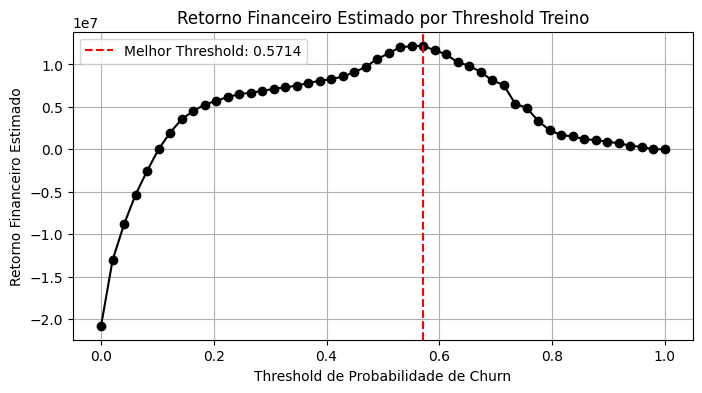

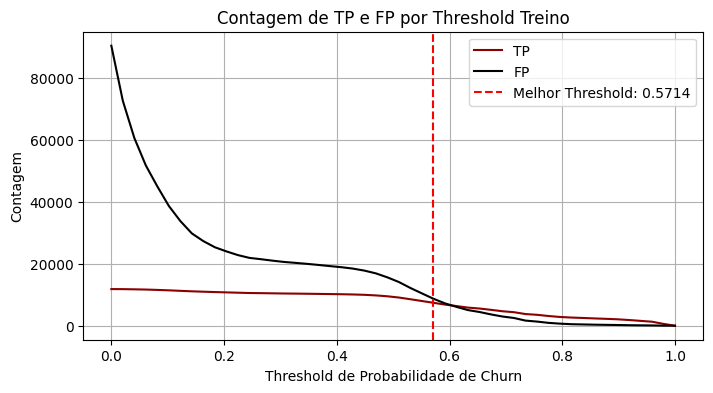

In [10]:
# Base de treino

# Iterar sobre diferentes thresholds
thresholds = np.linspace(0, 1, 50) # Testa thresholds de 0 a 1 com passos de 0.01
returns = []
tp_counts = []
fp_counts = []

for thresh in thresholds:
    financial_return, tp, fp = calculate_financial_return(train, thresh)
    returns.append(financial_return)
    tp_counts.append(tp)
    fp_counts.append(fp)

# Encontrar o threshold que maximiza o retorno financeiro
best_threshold_index = np.argmax(returns)
best_threshold = thresholds[best_threshold_index]
max_return = returns[best_threshold_index]

print(f"Melhor Threshold para maximizar o retorno financeiro: {best_threshold:.4f}")
print(f"Retorno Financeiro Máximo Estimado: {max_return:,.2f}")

plt.figure(figsize=(8, 4))
plt.plot(thresholds, returns, marker='o', linestyle='-', color="#000000")
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Melhor Threshold: {best_threshold:.4f}')
plt.title('Retorno Financeiro Estimado por Threshold Treino')
plt.xlabel('Threshold de Probabilidade de Churn')
plt.ylabel('Retorno Financeiro Estimado')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(thresholds, tp_counts, label='TP', color="#8B0000")
plt.plot(thresholds, fp_counts, label='FP', color="#000000")
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Melhor Threshold: {best_threshold:.4f}')
plt.title('Contagem de TP e FP por Threshold Treino')
plt.xlabel('Threshold de Probabilidade de Churn')
plt.ylabel('Contagem')
plt.grid(True)
plt.legend()
plt.show()

Melhor Threshold para maximizar o retorno financeiro: 0.5714
Retorno Financeiro Máximo Estimado: 1,200,895.87


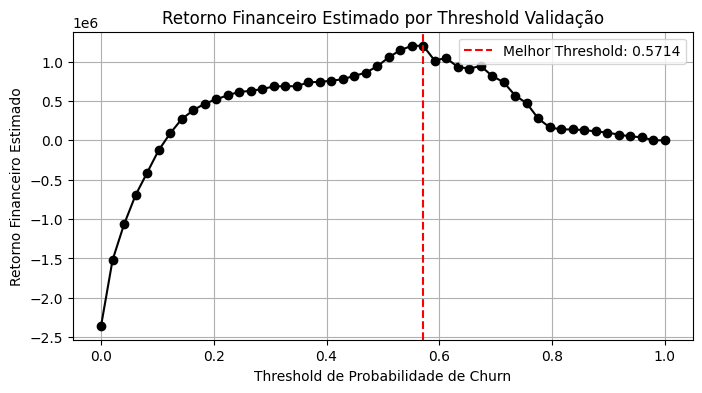

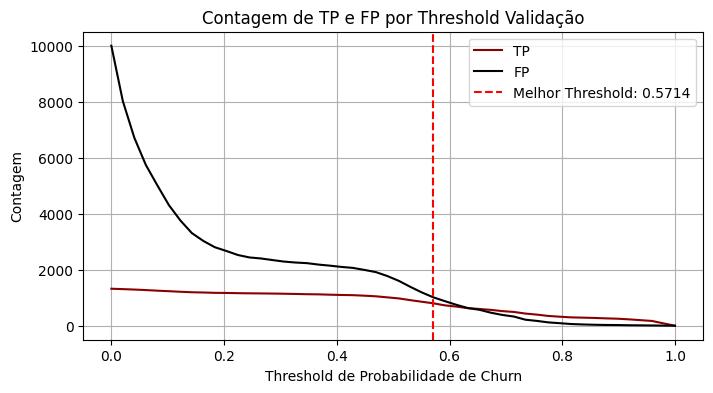

In [11]:
# Base de validação

# Iterar sobre diferentes thresholds
thresholds = np.linspace(0, 1, 50) # Testa thresholds de 0 a 1 com passos de 0.01
returns = []
tp_counts = []
fp_counts = []

for thresh in thresholds:
    financial_return, tp, fp = calculate_financial_return(valid, thresh)
    returns.append(financial_return)
    tp_counts.append(tp)
    fp_counts.append(fp)

# Encontrar o threshold que maximiza o retorno financeiro
best_threshold_index = np.argmax(returns)
best_threshold = thresholds[best_threshold_index]
max_return = returns[best_threshold_index]

print(f"Melhor Threshold para maximizar o retorno financeiro: {best_threshold:.4f}")
print(f"Retorno Financeiro Máximo Estimado: {max_return:,.2f}")

plt.figure(figsize=(8, 4))
plt.plot(thresholds, returns, marker='o', linestyle='-', color="#000000")
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Melhor Threshold: {best_threshold:.4f}')
plt.title('Retorno Financeiro Estimado por Threshold Validação')
plt.xlabel('Threshold de Probabilidade de Churn')
plt.ylabel('Retorno Financeiro Estimado')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(thresholds, tp_counts, label='TP', color="#8B0000")
plt.plot(thresholds, fp_counts, label='FP', color="#000000")
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Melhor Threshold: {best_threshold:.4f}')
plt.title('Contagem de TP e FP por Threshold Validação')
plt.xlabel('Threshold de Probabilidade de Churn')
plt.ylabel('Contagem')
plt.grid(True)
plt.legend()
plt.show()

## **Análise de impacto**

- Montagem de um fluxo de escoragem, utilizando um threshould de 0.57.
- Calculo do retorno financeiro
- Calculo da taxa de retenção dos clietes

In [12]:
def score_new_data(df):

    model_file_path = "/content/drive/MyDrive/Data Master/models/xgb_final_model.pkl"
    features_file_path = "/content/drive/MyDrive/Data Master/top_features.txt"

    threshold=0.57

    # Carregar o modelo treinado
    with open(model_file_path, 'rb') as f:
        model = pickle.load(f)
    print("Modelo carregado com sucesso!")

    # Carregar a lista de features selecionadas
    with open(features_file_path, 'r') as f:
        selected_features = [line.strip() for line in f if line.strip()]
    print(f"Features selecionadas carregadas: {selected_features}")

    X = df[selected_features]

    # --- Escoragem ---
    print("Escorando os novos dados...")
    probabilities = model.predict_proba(X)[:, 1]
    predictions = (probabilities >= threshold).astype(int)

    # Adicionar probabilidades e predições ao DataFrame original
    df['proba'] = probabilities
    df['prediction'] = predictions

    base['verdadeiro_churn'] = (base['target'] == 1) & (base['prediction'] == 1)
    base['falso_churn'] = (base['target'] == 0) & (base['prediction'] == 1)

    conditions = [
    df['verdadeiro_churn'] == True,
    df['falso_churn'] == True
    ]

    values = [
        df['actual_amount_paid']*9,
        -df['actual_amount_paid']*3
    ]
    base['impacto_financeiro'] = np.select(conditions, values, default=0)

    print("Escoragem concluída.")
    return df
train= pd.read_csv("/content/drive/MyDrive/Data Master/train.csv")
valid = pd.read_csv("/content/drive/MyDrive/Data Master/valid.csv")
test = pd.read_csv("/content/drive/MyDrive/Data Master/test.csv")
oot = pd.read_csv("/content/drive/MyDrive/Data Master/oot.csv")
train['base']='train'
valid['base']='valid'
test['base']='test'
oot['base']='oot'
base = pd.concat([train, valid, test, oot])
scored_data_df = score_new_data(base)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:39] WARNING: /workspace/src/gbm/gbtree.cc:363: 
  Loading from a raw memory buffer (like pickle in Python, RDS in R) on a CPU-only
  machine. Consider using `save_model/load_model` instead. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.  Changing `tree_method` to `hist`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:39] WARNING: /workspace/src/gbm/gbtree.cc:388: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:39] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserW

Modelo carregado com sucesso!
Features selecionadas carregadas: ['is_auto_renew_te', 'is_cancel_te', 'tempo_expiracao', 'actual_amount_paid', 'plan_list_price', 'registered_via_te', 'payment_plan_days', 'num_unq']
Escorando os novos dados...
Escoragem concluída.


<ipython-input-14-2768161362>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=impacto_por_safra, x='safra', y='impacto_financeiro', palette='Reds')


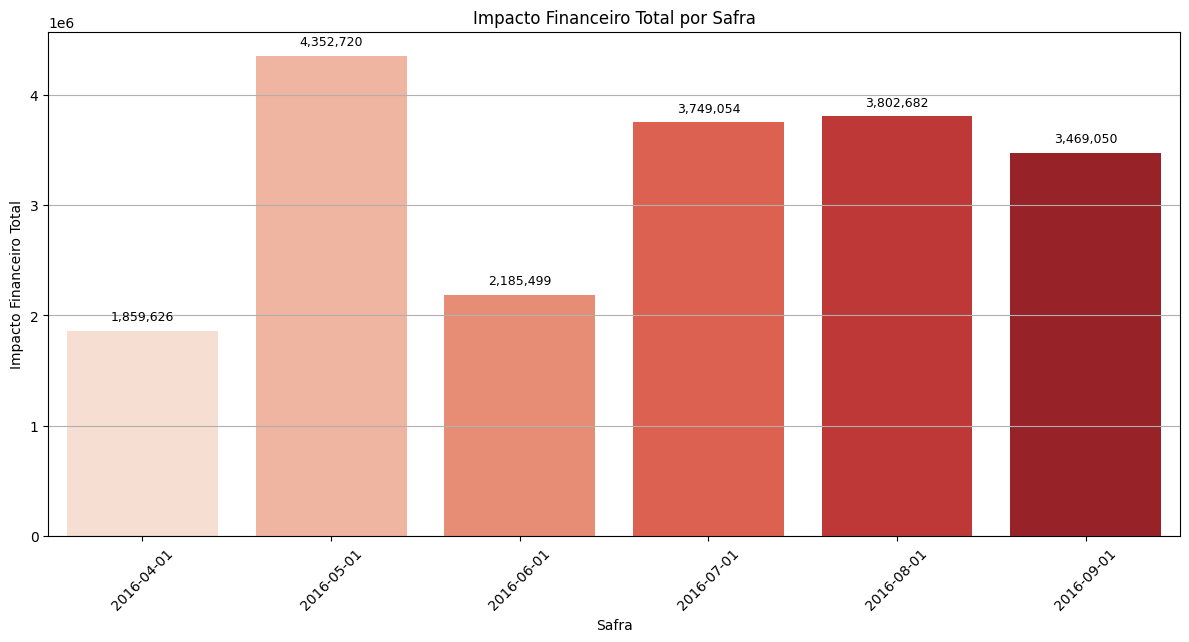

In [14]:
base['safra'] = pd.to_datetime(base['safra'])

# Calcular o total de impacto financeiro por safra
impacto_por_safra = base.groupby('safra')['impacto_financeiro'].sum().reset_index()

plt.figure(figsize=(12, 6))

ax = sns.barplot(data=impacto_por_safra, x='safra', y='impacto_financeiro', palette='Reds')

plt.xlabel('Safra')
plt.ylabel('Impacto Financeiro Total')
plt.title('Impacto Financeiro Total por Safra')
plt.grid(axis='y')
plt.tight_layout()
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points', fontsize=9)


plt.show()

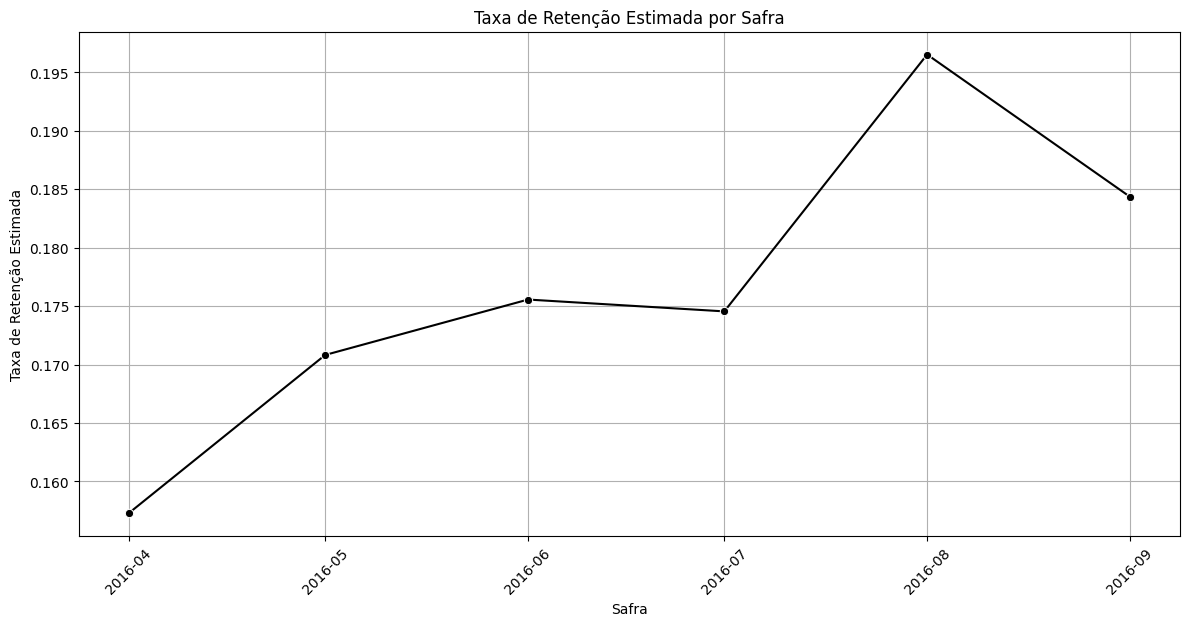

In [15]:
def calculate_safra_retention_rate(df):
  # Assume que 50% dos verdadeiros positivos são retidos
  df['retidos'] = ((df['target'] == 1) & (df['prediction'] == 1)) * 0.5

  # Calcular o número total de clientes na safra que não são verdadeiros negativos
  # Pois os verdadeiros negativos já estavam retidos e não são impactados pela ação proativa
  df['total_para_retencao'] = df.apply(
      lambda row: 1 if not (row['target'] == 0 and row['prediction'] == 0) else 0, axis=1
  )

  retention_by_safra = df.groupby('safra').agg(
      total_retidos=('retidos', 'sum'),
      total_clientes_safra=('total_para_retencao', 'sum')
  ).reset_index()

  retention_by_safra['taxa_retencao'] = (retention_by_safra['total_retidos'] / retention_by_safra['total_clientes_safra']).fillna(0)

  return retention_by_safra

# Calcular a taxa de retenção por safra na base escorada
retention_rate_by_safra = calculate_safra_retention_rate(scored_data_df)

# Plotar a taxa de retenção por safra
plt.figure(figsize=(12, 6))
sns.lineplot(data=retention_rate_by_safra, x='safra', y='taxa_retencao', marker='o', color="#000000")
plt.xlabel('Safra')
plt.ylabel('Taxa de Retenção Estimada')
plt.title('Taxa de Retenção Estimada por Safra')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [16]:
scored_data_df.to_csv('/content/drive/MyDrive/Data Master/base_escorada_churn.csv')

# **Análise não supervisionada**

Analise não supervisionada para compreensão das caracteristicas dos clientes da plataforma.

In [17]:
base = pd.read_csv('/content/drive/MyDrive/Data Master/base_escorada_churn.csv')
train = base[base['base']=='train']
valid = base[base['base']=='valid']
test = base[base['base']=='test']
oot = base[base['base']=='oot']

**Clusterização dos clientes**

Para compreender o perfil dos clientes classificados no modelo, opta-se por criar um modelo de clusterização usando k-means clustering, agrupando os clientes com perfis diferentes e analisando seu comportamento.

Análise do perfil:
- Como ele consome a plataforma? -> tempo e quantidade de tempo escutado
- Quanto paga pelo servico de assinatura? Por quanto tempo ainda tem assinatura valida até o proximo pagamento?
- A quanto tempo começou a utilizar a plataforma?
- Qual idade desse cliente?

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Variaveis selecionadas
cols = ['bd','actual_amount_paid', 'num_25', 'num_50',	'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs', 'tempo_expiracao', 'tempo_iniciacao']
X_train = train[cols]
X_valid = valid[cols]
X_test = test[cols]
X_oot = oot[cols]
X_completo=base[cols]

# Criação do pipeline: Escalonamento + PCA
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

# Ajuste do pipeline nos dados selecionados
X_train_pca = pca_pipeline.fit_transform(X_train)
X_valid_pca = pca_pipeline.transform(X_valid)
X_test_pca = pca_pipeline.transform(X_test)
X_oot_pca = pca_pipeline.transform(X_oot)
X_base_pca = pca_pipeline.transform(X_completo)

# Criar um DataFrame com os componentes principais
pca_cols = [f'pca_component_{i+1}' for i in range(pca_pipeline.named_steps["pca"].n_components)]
X_train = pd.concat([X_train.reset_index(drop=True), pd.DataFrame(X_train_pca, columns=pca_cols)], axis=1)

print("Dataframe com componentes PCA:")
X_train.head()

Dataframe com componentes PCA:


,bd,actual_amount_paid,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,tempo_expiracao,tempo_iniciacao,pca_component_1,pca_component_2
0,17.0,99.0,114.528787,28.740476,18.008591,20.255956,536.278642,526.428807,141709.311191,34.0,271.0,-0.011691,-1.283976
1,29.0,149.0,283.000000,62.000000,41.000000,45.000000,3577.200000,2865.000000,900460.786800,44.0,1387.0,7.100234,2.124009
2,25.0,129.0,138.000000,44.000000,24.000000,19.000000,1229.000000,1322.000000,300332.541000,19.0,696.0,1.715574,-0.300004
3,17.0,149.0,58.000000,27.000000,20.000000,11.000000,1108.000000,483.000000,243377.255000,40.0,933.0,0.261628,-0.354462
4,26.0,149.0,33.000000,15.000000,10.000000,18.000000,919.000000,924.000000,240312.504000,52.0,1986.0,0.247788,1.104968


Text(0, 0.5, 'SSE')

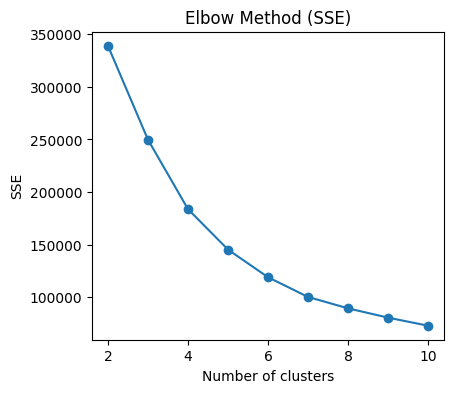

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Encontrar o melhor número de clusters (Elbow Curve)
sse = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_train_pca)
    sse.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(K_range, sse, marker='o')
plt.title('Elbow Method (SSE)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [21]:
# Escolha do melhor número de clusters
best_k = 4

# Treinando o modelo final
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_train_pca)
cluster_test = kmeans.predict(X_test_pca)
cluster_valid = kmeans.predict(X_valid_pca)
cluster_oot = kmeans.predict(X_oot_pca)
cluster_base = kmeans.predict(X_base_pca)

# Adicionando o cluster ao DataFrame original
train['cluster'] = cluster_labels
valid['cluster'] = cluster_valid
test['cluster'] = cluster_test
oot['cluster'] = cluster_oot
base['cluster'] = cluster_base

# Avaliando o resultado
print('Silhouette Score final:', silhouette_score(X_train, cluster_labels))

# Salvando o modelo e o pca usando pickle (pkl)
with open('pca_pipeline.pkl', 'wb') as f:
    pickle.dump(pca_pipeline, f)
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

<ipython-input-21-1295312284>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cluster'] = cluster_labels
<ipython-input-21-1295312284>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['cluster'] = cluster_valid
<ipython-input-21-1295312284>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Silhouette Score final: 0.15405735457977787


## **Análise dos clusters**
1) Análise de clientes com diferentes perfis de uso da plataforma com as variadas estimações de churn

2) Análise de perfis de clientes com diferentes volatilidades/incertezas nas rspostas de churn

3) Análise de erros sistemáticos cometidos pelos modelos do case supervisionado

4) Análise de variação temporal no comportamento dos clientes de base

### **Perfil das variáveis por cluster estável ao longo das safras.**

**Cluster 0:**
- Pessoas mais jovens, que pagam em o plano que não é o mais barato
- Não tão fidelizados
- Taxa de churn maior
- Alto percentual de incerteza nas previsões de churn
- Maior quantidade de falsos negativos

**Cluster 1:**

- Clientes menos fidelizados
- Maior taxa de churn e menos músicas escutadas
- Menor valor médio pago na assinatura e clientes mais jovens.
- Percentual reduzido de incertezas nas previsões de churn

**Cluster 2:**
- Público ainda jovem porém, o mais fidelizado, com menor percentual de churn
- Consome muitos minutos na plataforma e já são clientes a mais tempo
- Baixo percentual de incerteza nas previsões de churn
- Menor quantidade de falsos positivos

**Cluster 3:**
- Público mais velho
- Maiores consumidores da plataforma em minutos
- Já são clientes a bastante tempo
- Maior percentual de churn
- Maior percentual de incerteza nas previsoes de churn
- Maior quantidade de falsos positivos

<ipython-input-24-285663619>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=base, palette='Reds')


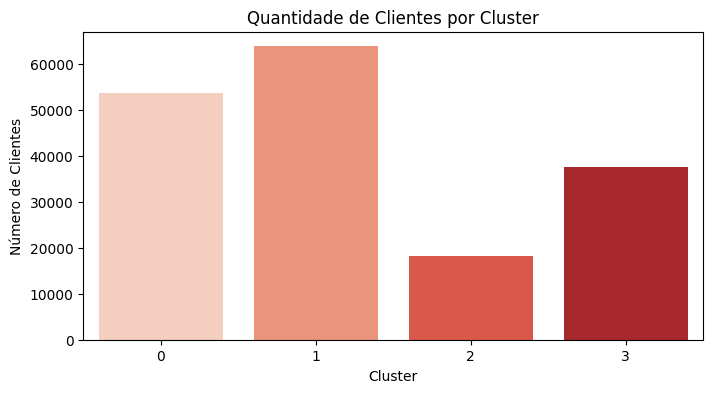

In [24]:
# Visualizar a quantidade de clientes por cluster
plt.figure(figsize=(8, 4))
sns.countplot(x='cluster', data=base, palette='Reds')
plt.title('Quantidade de Clientes por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Clientes')
plt.show()

<ipython-input-25-4098073753>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churn_by_cluster, x='cluster', y='percentual_churn', palette='Reds')


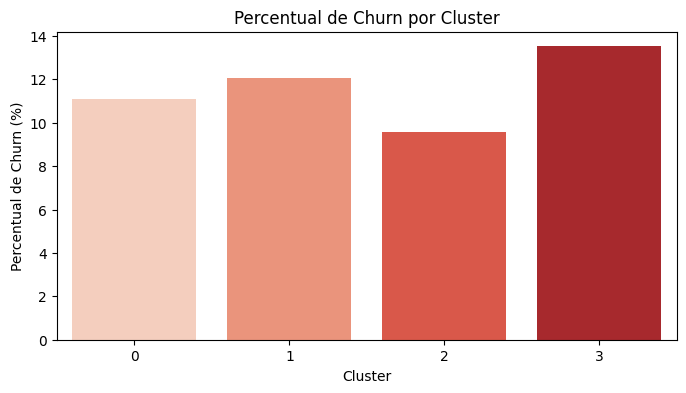

In [25]:
# Analisando a relação entre clusters e churn
churn_by_cluster = base.groupby('cluster')['target'].mean().reset_index()
churn_by_cluster.columns = ['cluster', 'percentual_churn']
churn_by_cluster['percentual_churn'] = round(churn_by_cluster['percentual_churn'] * 100, 2)

plt.figure(figsize=(8, 4))
sns.barplot(data=churn_by_cluster, x='cluster', y='percentual_churn', palette='Reds')
plt.title('Percentual de Churn por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentual de Churn (%)')
plt.show()

In [26]:
# Resumo qualitativo dos Clusters
print("\nSumário Qualitativo dos Clusters:")
print("Cluster 0:")
print(base[base['cluster']==0][cols].mean())
print(f"Percentual de Churn: {churn_by_cluster[churn_by_cluster['cluster']==0]['percentual_churn'].iloc[0]}%")

print("\nCluster 1:")
print(base[base['cluster']==1][cols].mean())
print(f"Percentual de Churn: {churn_by_cluster[churn_by_cluster['cluster']==1]['percentual_churn'].iloc[0]}%")

print("\nCluster 2:")
print(base[base['cluster']==2][cols].mean())
print(f"Percentual de Churn: {churn_by_cluster[churn_by_cluster['cluster']==2]['percentual_churn'].iloc[0]}%")

print("\nCluster 3:")
print(base[base['cluster']==3][cols].mean())
print(f"Percentual de Churn: {churn_by_cluster[churn_by_cluster['cluster']==3]['percentual_churn'].iloc[0]}%")


Sumário Qualitativo dos Clusters:
Cluster 0:
bd                        20.212094
actual_amount_paid       239.051803
num_25                   151.608076
num_50                    37.997172
num_75                    23.708743
num_985                   25.632211
num_100                  605.316242
num_unq                  633.304308
total_secs            162389.811038
tempo_expiracao           46.354490
tempo_iniciacao          794.747352
dtype: float64
Percentual de Churn: 11.08%

Cluster 1:
bd                       19.843816
actual_amount_paid      188.387550
num_25                   34.595268
num_50                    8.946749
num_75                    5.571578
num_985                   5.886859
num_100                 153.698733
num_unq                 162.730315
total_secs            41164.584913
tempo_expiracao          45.584482
tempo_iniciacao         741.671051
dtype: float64
Percentual de Churn: 12.07%

Cluster 2:
bd                        24.437424
actual_amount_paid       36

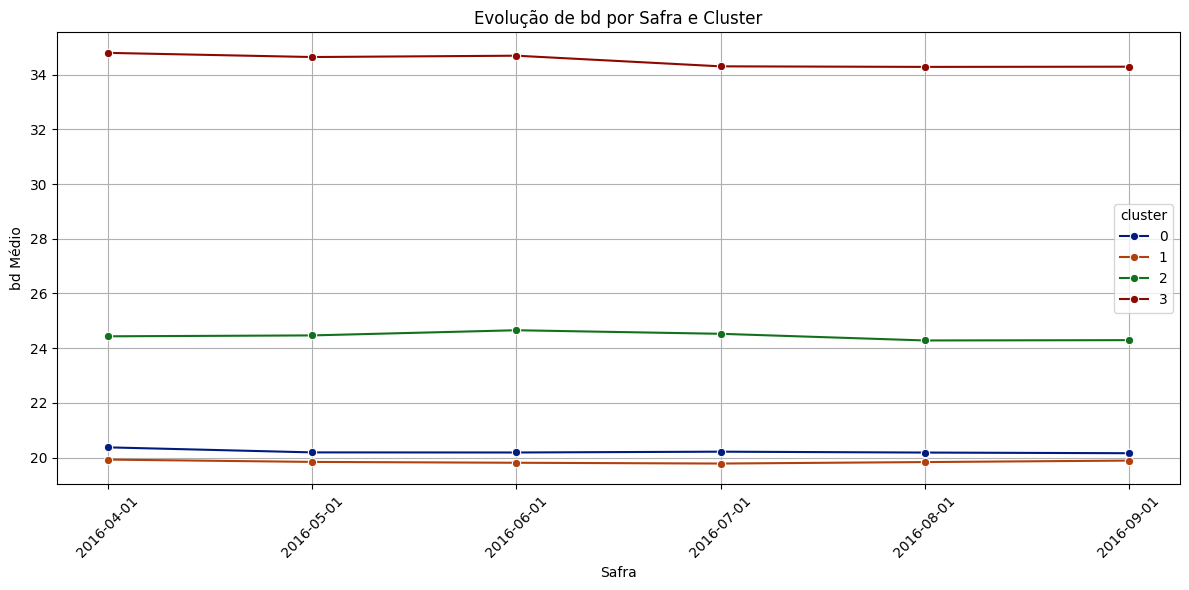

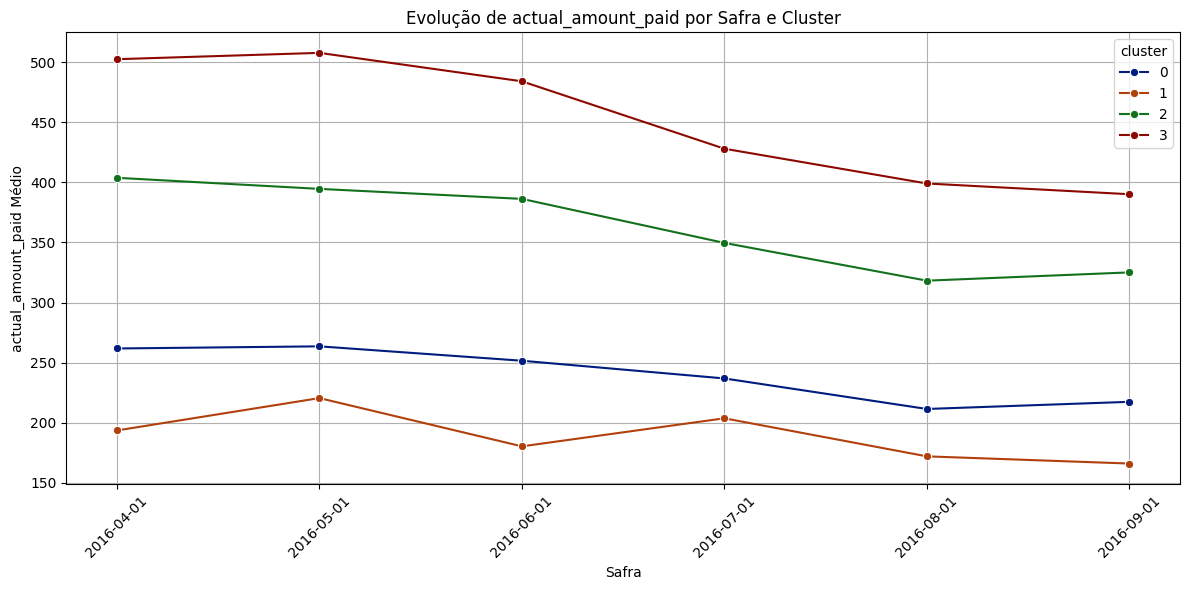

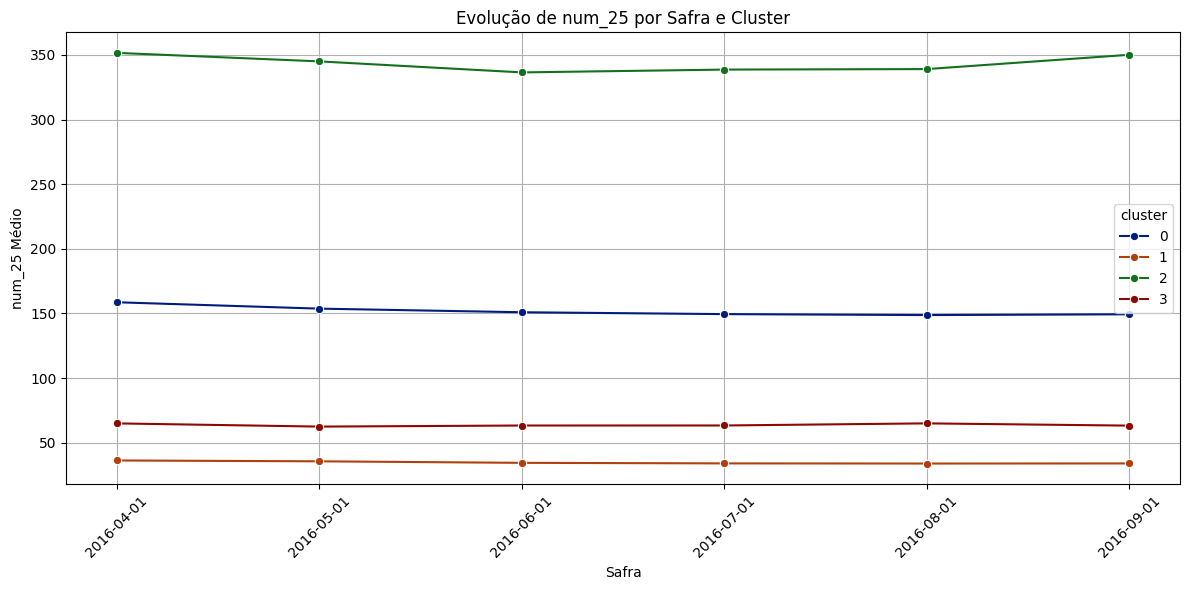

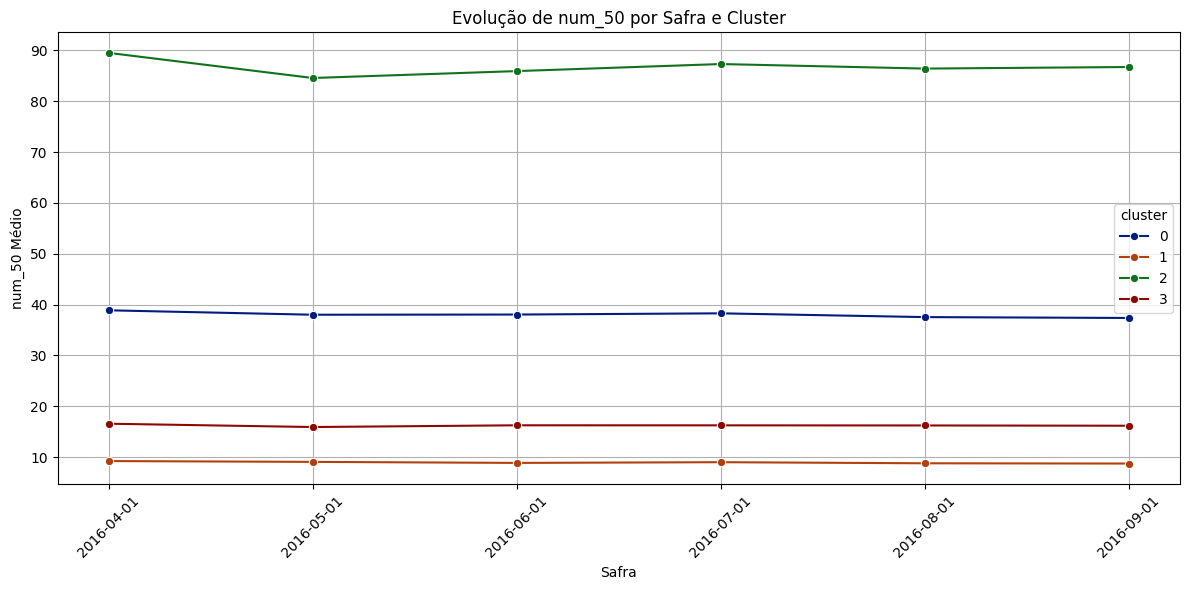

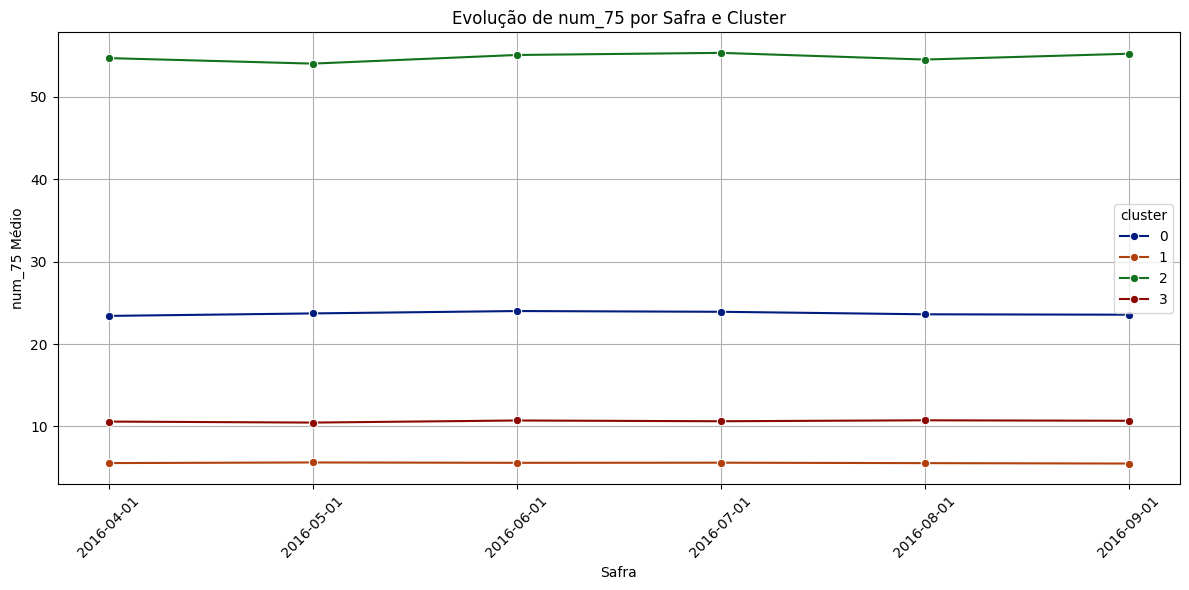

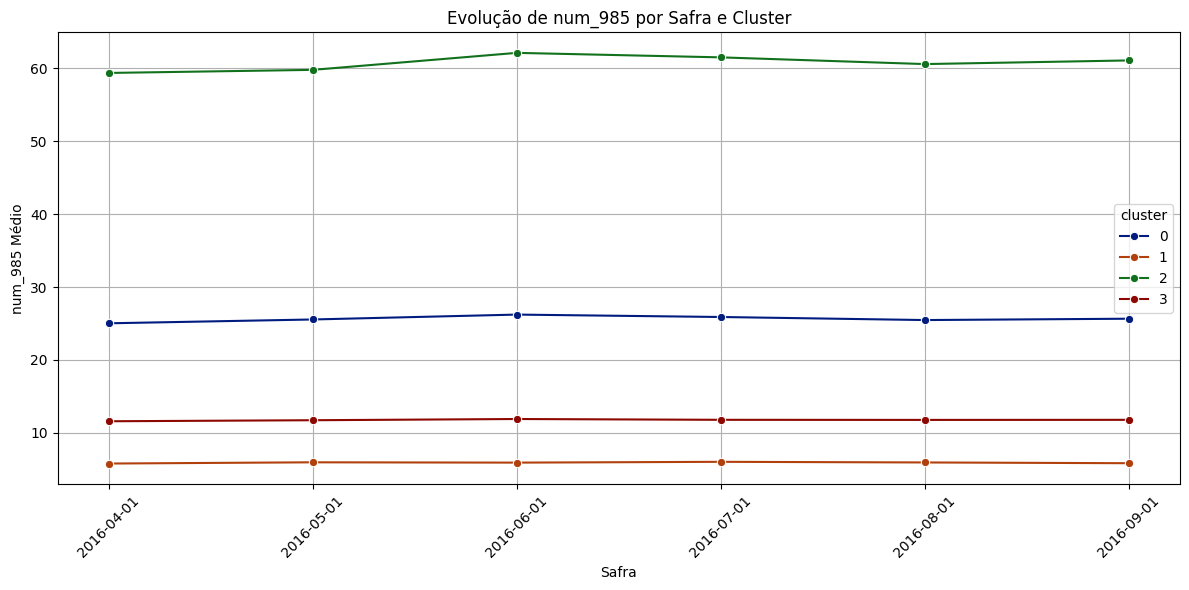

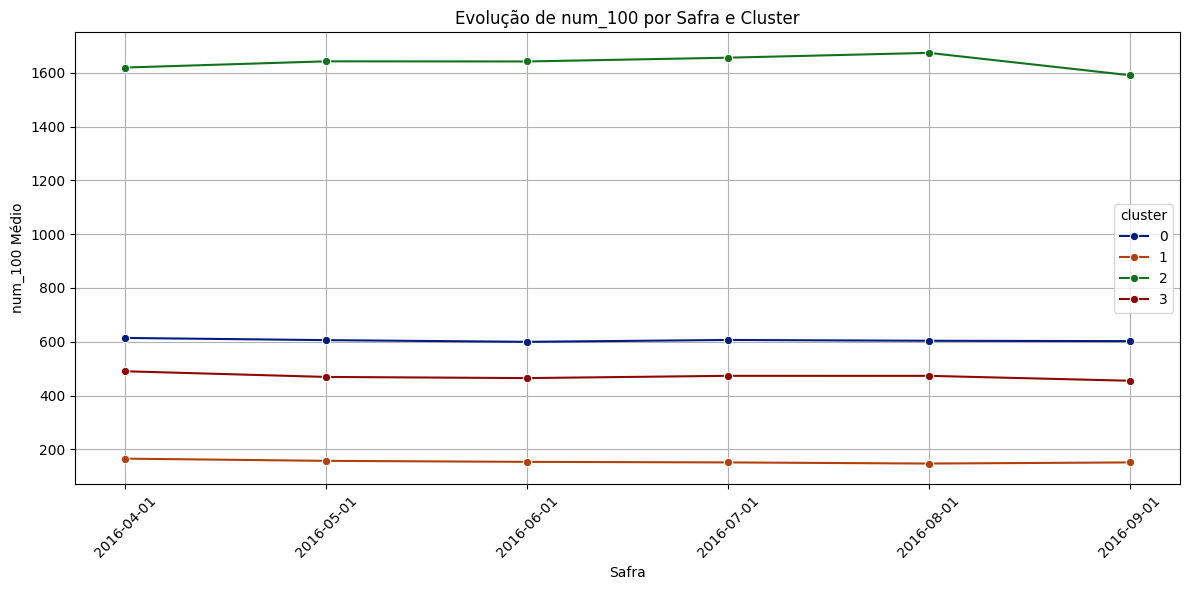

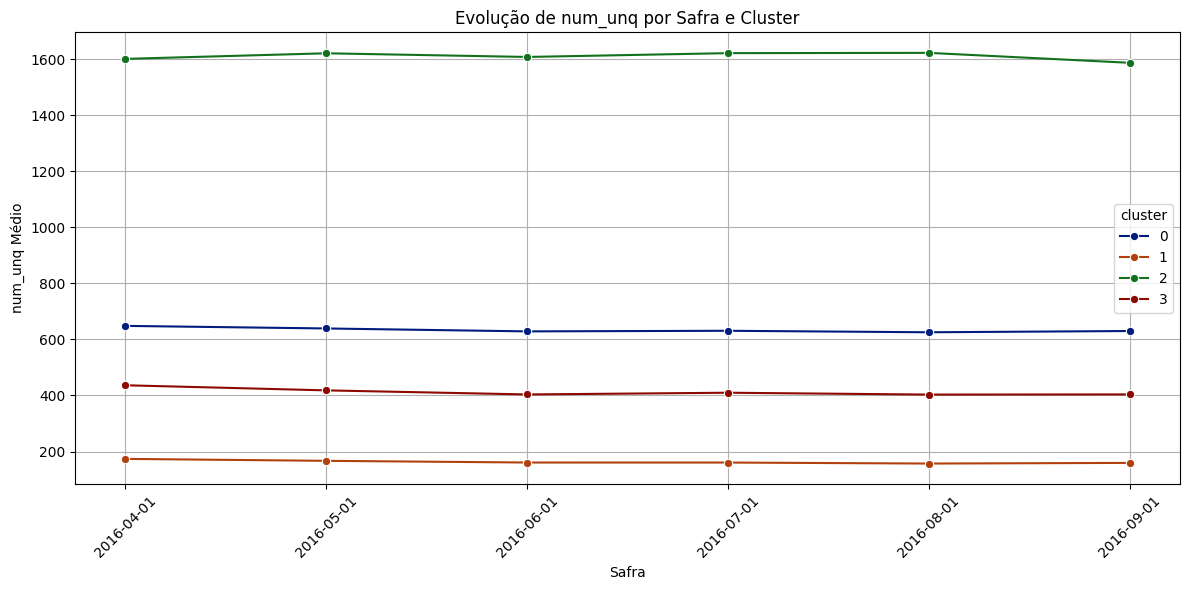

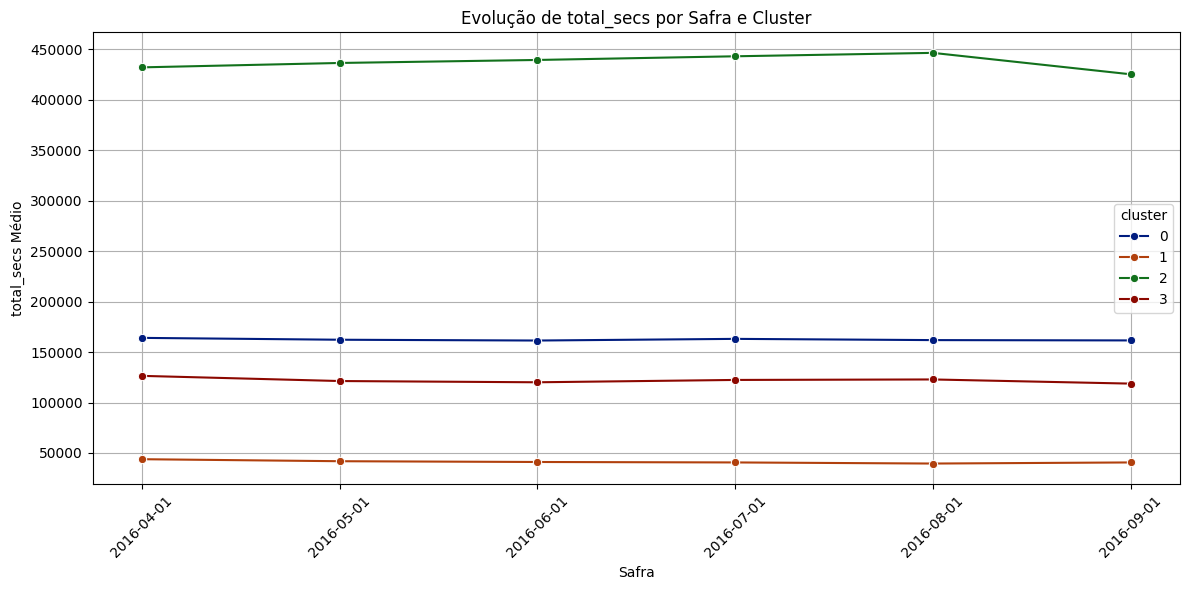

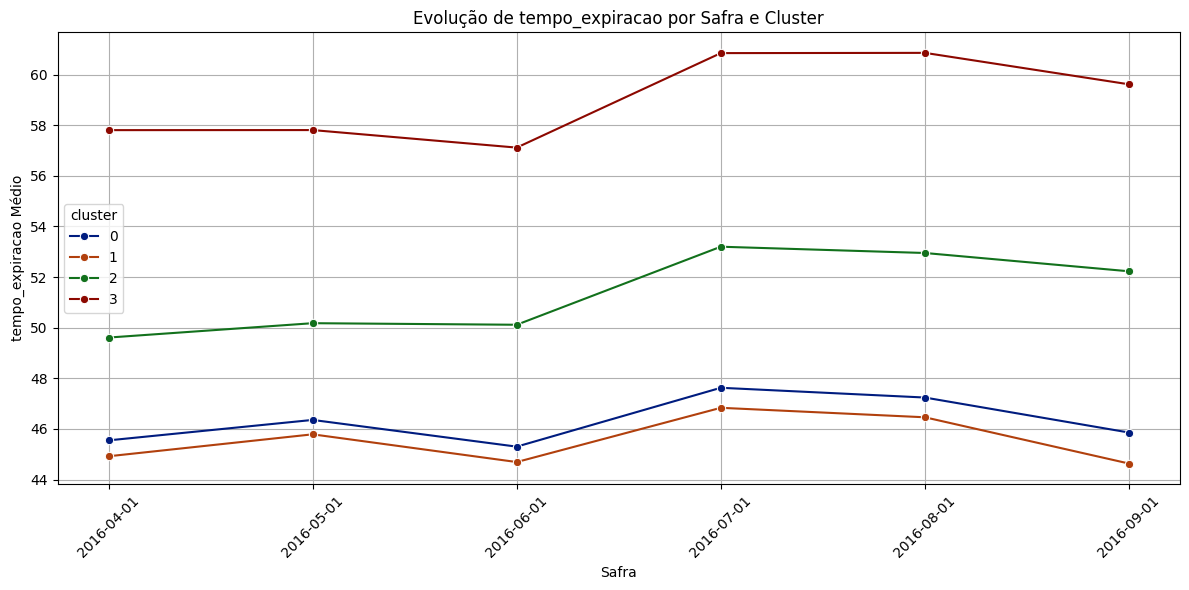

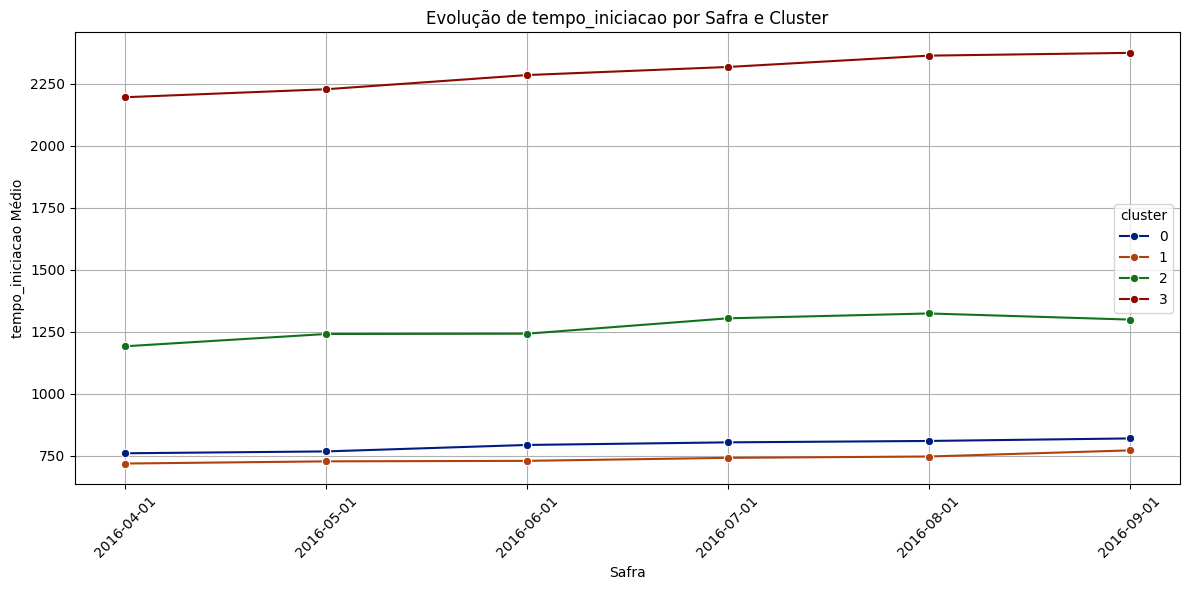

In [27]:
# Análise do perfil dos clusters em relação às variáveis originais
profile_by_cluster_safra = base.groupby(['safra', 'cluster'])[cols].mean().reset_index()

for i in cols:
  plt.figure(figsize=(12, 6))
  sns.lineplot(data=profile_by_cluster_safra, x='safra', y=i, hue='cluster', marker='o', palette='dark')
  plt.title(f'Evolução de {i} por Safra e Cluster')
  plt.xlabel('Safra')
  plt.ylabel(f'{i} Médio')
  plt.xticks(rotation=45)
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [28]:
# Análise dos clientes com maior volatilidade/incerteza nas respostas de churn (baseado na probabilidade)
# Clientes próximos ao threshold de classificação (0.7) podem ser considerados mais incertos.
# Análise dos clientes com probabilidade entre (threshold - epsilon) e (threshold + epsilon)
optimal_threshold = 0.7
epsilon = 0.1

# Seleciona os clientes incertos
uncertain_clients = base[
    (base['proba'] >= (optimal_threshold - epsilon)) &
    (base['proba'] <= (optimal_threshold + epsilon))
]

# Agrupa por cluster, calcula quantidade
cluster_counts = uncertain_clients.groupby('cluster').size().reset_index(name='count')

# Calcula o percentual de cada cluster entre os clientes incertos
total_uncertain = len(uncertain_clients)
cluster_counts['percent'] = 100 * cluster_counts['count'] / total_uncertain

print(f"\nAnálise de Clientes Incertos (Proba entre {optimal_threshold - epsilon:.2f} e {optimal_threshold + epsilon:.2f}):")
print(cluster_counts)
print(f"\nTotal de clientes incertos: {total_uncertain}")



Análise de Clientes Incertos (Proba entre 0.60 e 0.80):
   cluster  count    percent
0        0   3583  21.507894
1        1   7517  45.122756
2        2    445   2.671229
3        3   5114  30.698121

Total de clientes incertos: 16659


In [29]:
# Análise de erros sistemáticos do modelo supervisionado por cluster
# Falsos Positivos (FP): Modelo previu churn (prediction=1), mas não foi (target=0)
# Falsos Negativos (FN): Modelo previu não-churn (prediction=0), mas foi churn (target=1)

fp_clients = base[(base['target'] == 0) & (base['prediction'] == 1)]
fn_clients = base[(base['target'] == 1) & (base['prediction'] == 0)]

fp_qtd = fp_clients.groupby('cluster').size().reset_index(name='count')
total_fp_clients = len(fp_clients)
fp_qtd['percent'] = 100 * fp_qtd['count'] / total_fp_clients

print("\nAnálise de Falsos Positivos por Cluster:")
print(fp_qtd)

fn_qtd = fn_clients.groupby('cluster').size().reset_index(name='count')
total_fn_clients = len(fn_clients)
fn_qtd['percent'] = 100 * fn_qtd['count'] / total_fn_clients
print("\nAnálise de Falsos Negativos por Cluster:")
print(fn_qtd)


Análise de Falsos Positivos por Cluster:
   cluster  count    percent
0        0   3441  22.792608
1        1   6190  41.001523
2        2    545   3.609989
3        3   4921  32.595880

Análise de Falsos Negativos por Cluster:
   cluster  count    percent
0        0   2655  33.757152
1        1   1551  19.720280
2        2   1458  18.537826
3        3   2201  27.984743


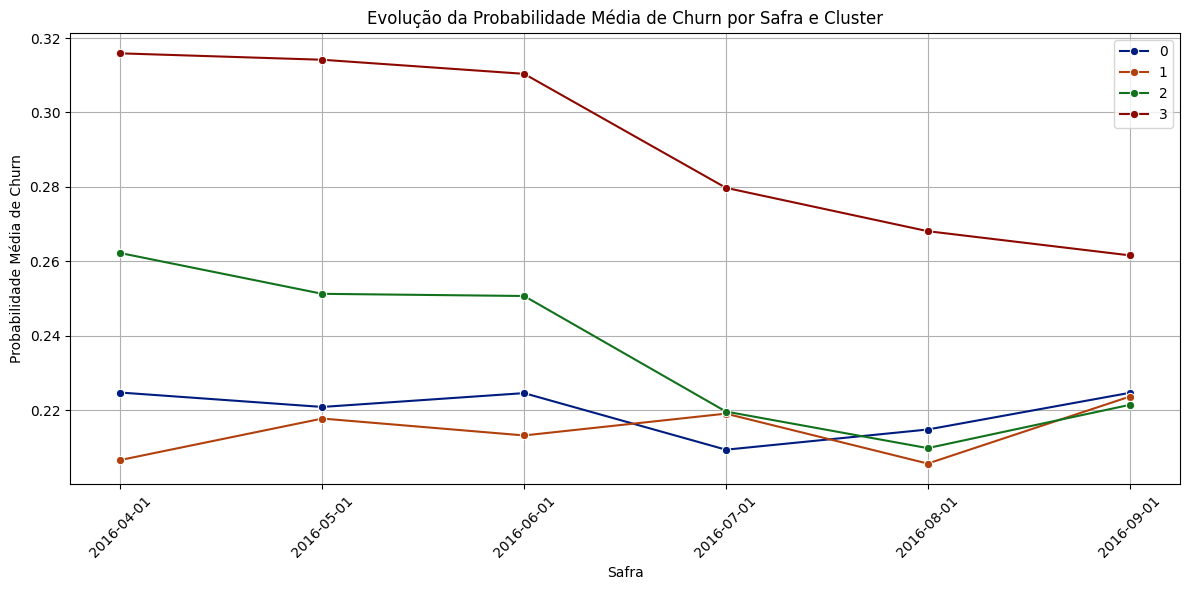

In [31]:
# Variação temporal no comportamento dos clientes de base
# Análise das Probabilidades de Churn por Cluster ao longo do Tempo (Safra)
proba_by_cluster_safra = base.groupby(['safra', 'cluster'])['proba'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=proba_by_cluster_safra, x='safra', y='proba', hue='cluster', marker='o', palette='dark')
plt.title('Evolução da Probabilidade Média de Churn por Safra e Cluster')
plt.xlabel('Safra')
plt.ylabel('Probabilidade Média de Churn')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()